In [1]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pickle

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.signal import find_peaks

In [3]:

df_jus = pd.read_csv('Telemetria_Construserv_2025-09-17_jusante.csv', encoding='ISO-8859-1',
                 sep=';',skiprows=1, skipfooter=1, engine='python', decimal=',',
                na_values = '-', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0',
                dayfirst=True)

df_jus.index.name='timestamp'
df_jus.index = pd.to_datetime(df_jus.index, format="%d/%m/%Y %H:%M", dayfirst=True, errors='coerce')
#df_jus

In [5]:
df_mon = pd.read_csv('Telemetria_Construserv_2025-09-17_montante.csv', encoding='ISO-8859-1',
                 sep=';',skiprows=1, skipfooter=1, engine='python', decimal=',',
                na_values = '-', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0',
                dayfirst=True)

df_mon.index.name='timestamp'
df_mon.index = pd.to_datetime(df_mon.index, format="%d/%m/%Y %H:%M", dayfirst=True, errors='coerce')
#df_mon

In [6]:
df_jus.describe()

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
count,31906.000000,31906.000000,31906.000000
mean,0.078988,119.337899,3.909092
std,0.771692,24.104387,4.752410
min,0.000000,55.000000,0.000000
25%,0.000000,104.000000,1.900000
50%,0.000000,113.000000,2.570000
75%,0.000000,125.000000,4.000000
max,42.400000,412.000000,107.120000


In [7]:
df_mon.describe()

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
count,47357.000000,47357.000000,46776.000000
mean,0.105788,145.522858,9.874709
std,1.040956,118.753912,45.600956
min,0.000000,-525.000000,0.000000
25%,0.000000,122.000000,1.720000
50%,0.000000,135.000000,4.120000
75%,0.000000,149.000000,5.230000
max,63.000000,1035.000000,368.860000


# Visualização das Séries

In [8]:
def plot_series(df_jus, df_mon):
    
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    plt.plot(df_jus.index, df_jus["Nível (cm)"])

    locator = mdates.MonthLocator(bymonthday=1)
    formatter = mdates.DateFormatter("%m/%Y")
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    #plt.title("Nível a jusante")
    plt.ylabel("Nível (cm)")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(df_mon.index, df_mon["Nível (cm)"])
    
    locator = mdates.MonthLocator(bymonthday=1)
    formatter = mdates.DateFormatter("%m/%Y")
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    #plt.title("Nível a montante")
    plt.ylabel("Nível (cm)")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def plot_violin(df, estacao):
    plt.figure(figsize=(8,6))
    sns.violinplot(y=df["Nível (cm)"], bw_method=0.4, color='skyblue')
    plt.title(f'Distribuição de Nível a {estacao}')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.axhline(y=df['Nível (cm)'].median(), color='red', linestyle='--', linewidth=1.5, label='Mediana')
    plt.axhline(y=df['Nível (cm)'].quantile(0.25), color='green', linestyle='--', linewidth=1.5, label='Q1 (25%)')
    plt.axhline(y=df['Nível (cm)'].quantile(0.75), color='orange', linestyle='--', linewidth=1.5, label='Q3 (75%)')
    
    plt.legend()
    plt.show()


def plot_violin_box(df, estacao):
    # Violin plot
    plt.figure(figsize=(6,6))
    sns.violinplot(y=df["Nível (cm)"], bw_method=0.4, color='skyblue', inner='quartile')
    plt.title(f'Violin Plot - {estacao}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # Boxplot
    plt.figure(figsize=(6,6))
    sns.boxplot(y=df["Nível (cm)"], color='lightgrey', fliersize=3)
    plt.title(f'Box Plot - {estacao}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def plot_violin_and_boxplot(df, estacao):
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True) 

    
    median_val = df['Nível (cm)'].median()
    q1_val = df['Nível (cm)'].quantile(0.25)
    q3_val = df['Nível (cm)'].quantile(0.75)

    sns.violinplot(y=df["Nível (cm)"], bw_method=0.4, color='skyblue', ax=axes[0])
    axes[0].set_title(f'Distribuição de Nível em {estacao} (Violino)')
    axes[0].grid(True, linestyle='--', alpha=0.7)
    

    axes[0].axhline(y=median_val, color='red', linestyle='--', linewidth=1.5, label='Mediana')
    axes[0].axhline(y=q1_val, color='green', linestyle='--', linewidth=1.5, label='Q1 (25%)')
    axes[0].axhline(y=q3_val, color='orange', linestyle='--', linewidth=1.5, label='Q3 (75%)')
    axes[0].legend()

    sns.boxplot(y=df["Nível (cm)"], color='lightcoral', ax=axes[1])
    axes[1].set_title(f'Distribuição de Nível em {estacao} (Boxplot)')
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    axes[1].axhline(y=median_val, color='red', linestyle='--', linewidth=1, label='Mediana')
    axes[1].axhline(y=q1_val, color='green', linestyle='--', linewidth=1, label='Q1')
    axes[1].axhline(y=q3_val, color='orange', linestyle='--', linewidth=1, label='Q3')
    axes[1].legend()

    plt.tight_layout()

    plt.show()

In [9]:
df_jus_diario = df_jus.resample('D').max()
df_mon_diario = df_mon.resample('D').max()

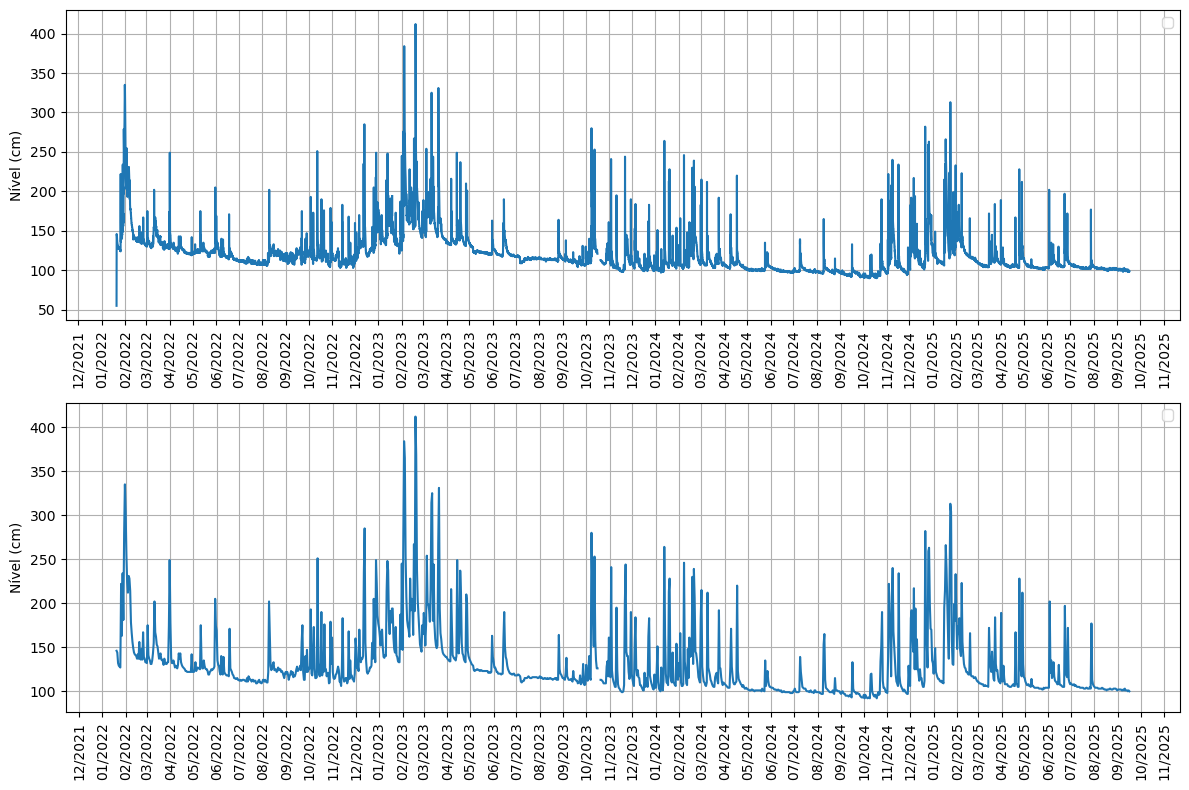

In [10]:
plot_series(df_jus, df_jus_diario)

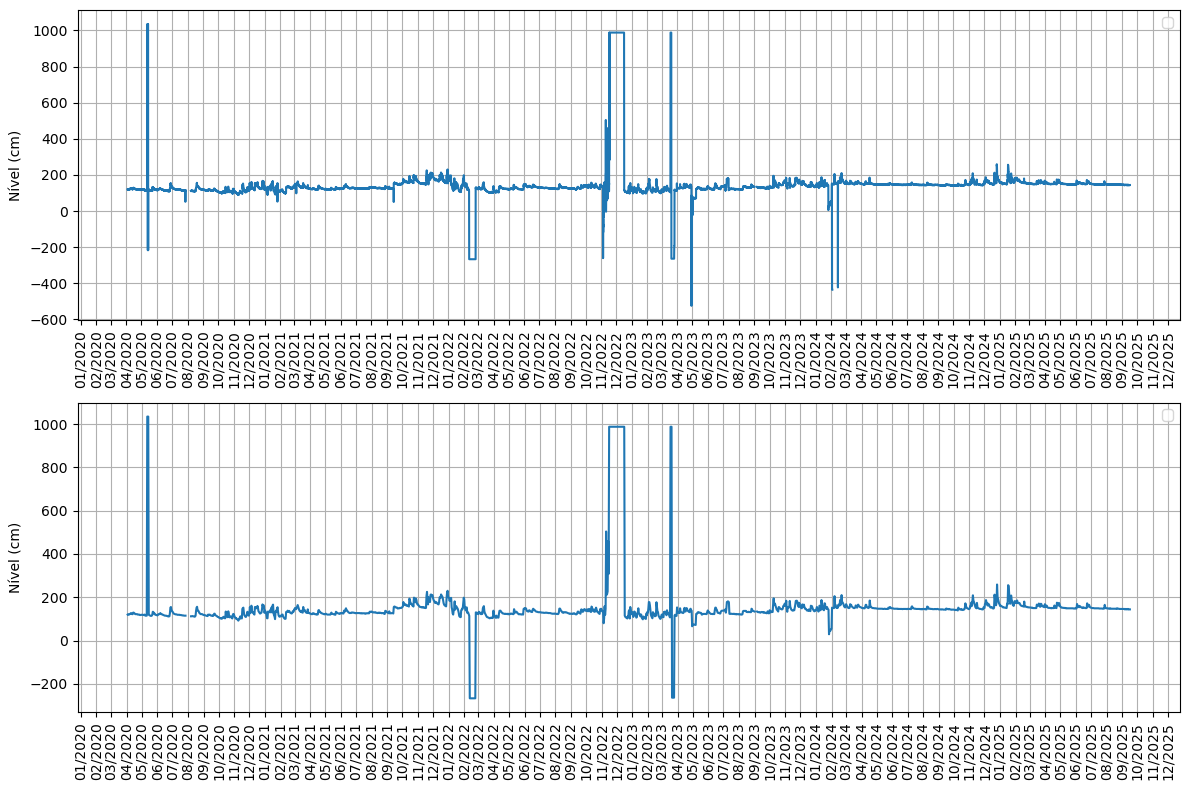

In [11]:
plot_series(df_mon, df_mon_diario)

## Análise de distribuição

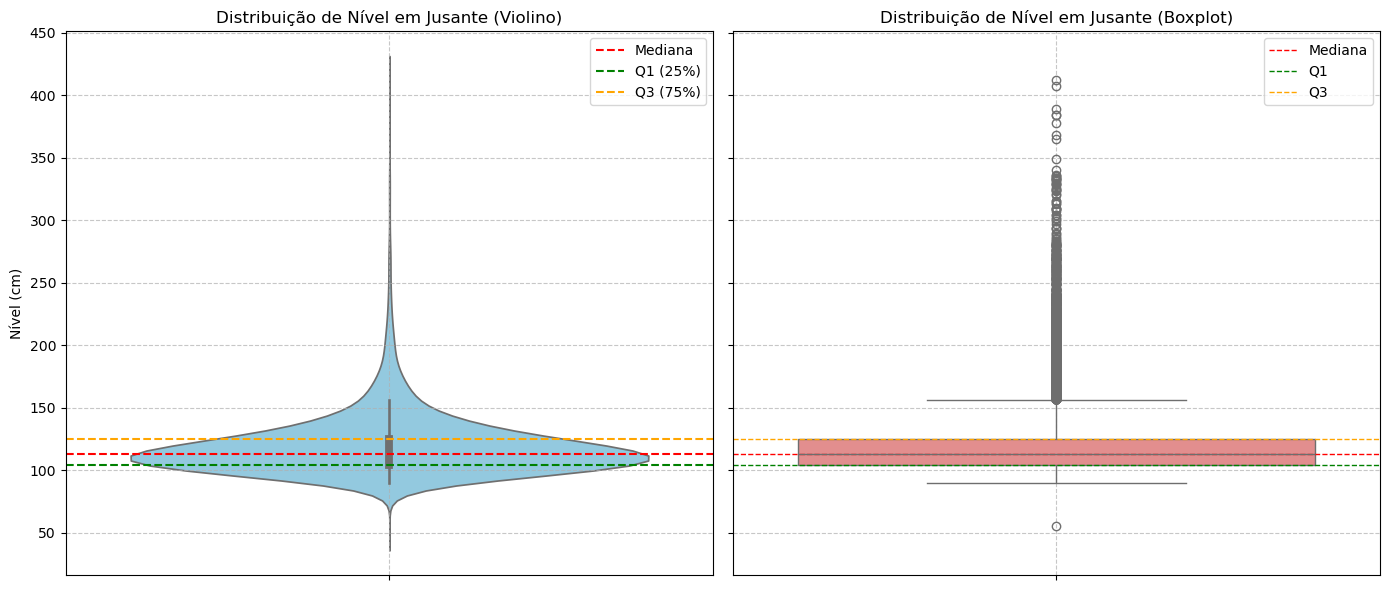

In [12]:
plot_violin_and_boxplot(df_jus, 'Jusante')

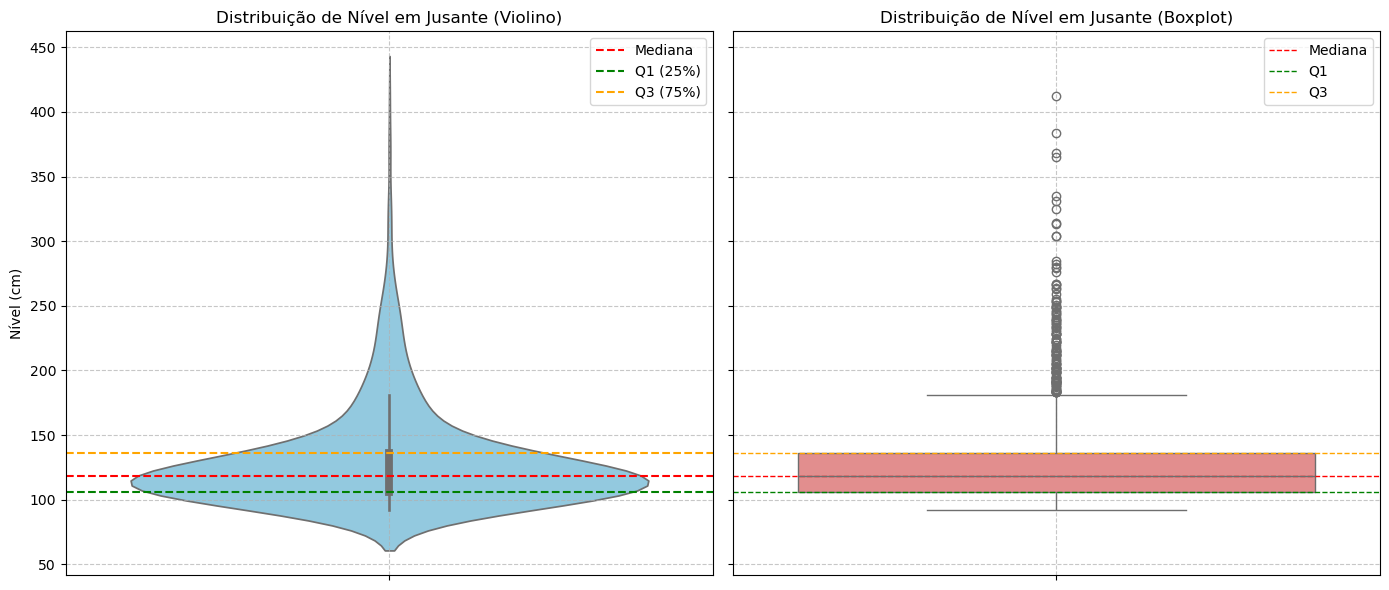

In [13]:
plot_violin_and_boxplot(df_jus_diario, 'Jusante')

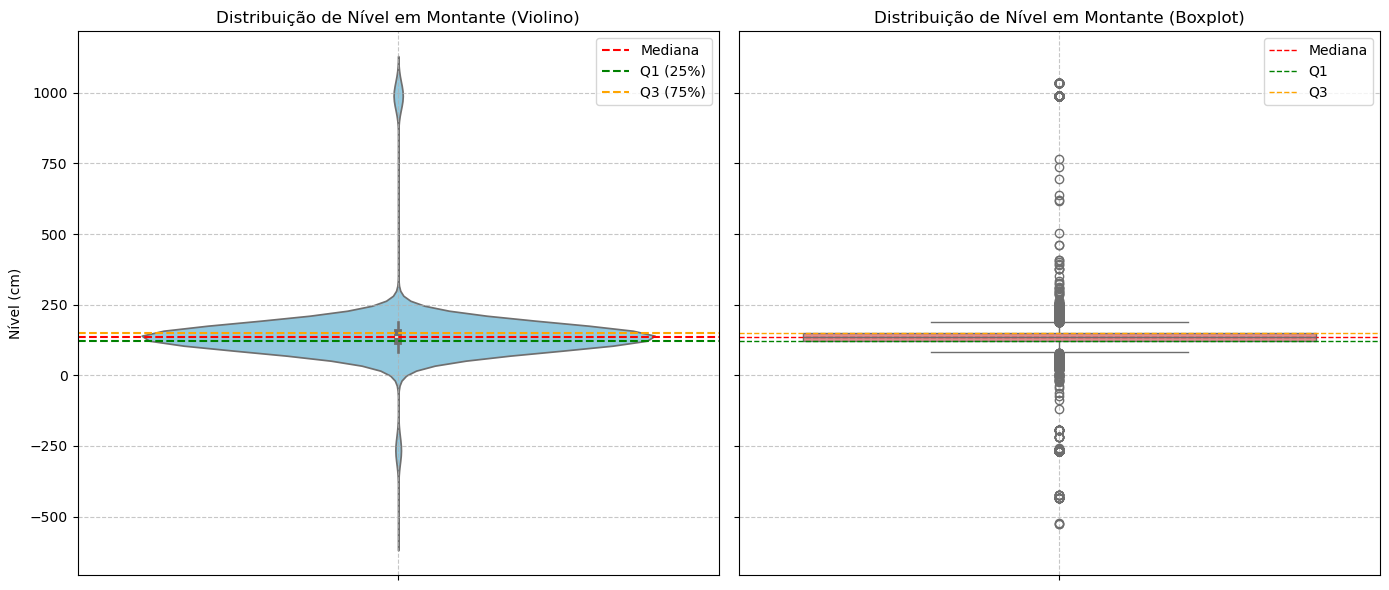

In [14]:
plot_violin_and_boxplot(df_mon, 'Montante')

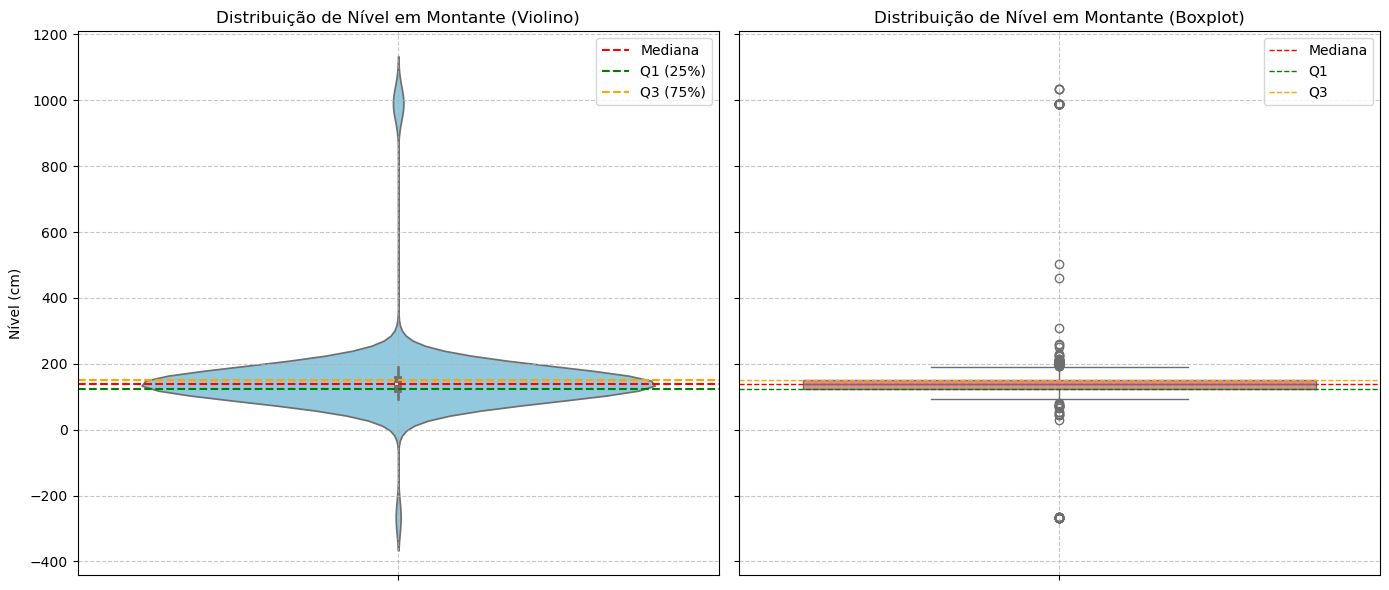

In [15]:
plot_violin_and_boxplot(df_mon_diario, 'Montante')

## Tratamento Outlyers

In [16]:
def tratar_outliers_iqr(df, coluna, fator=1.5, q1=0.05, q3=0.95):

    df_copy = df.copy()
    
    Q1 = df_copy[coluna].quantile(q1)
    Q3 = df_copy[coluna].quantile(q3)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - fator * IQR
    limite_superior = Q3 + fator * IQR

    # média apenas dos valores válidos (não outliers, >=0 e <=800)
    media_valida = df_copy[coluna][(df_copy[coluna] >= 0) & 
                                   (df_copy[coluna] >= limite_inferior) & 
                                   (df_copy[coluna] <= limite_superior) & 
                                   (df_copy[coluna] <= 800)].mean()
    
    # substitui valores inválidos pela média válida
    df_copy[coluna] = df_copy[coluna].mask((df_copy[coluna] < 0) | 
                                           (df_copy[coluna] < limite_inferior) | 
                                           (df_copy[coluna] > limite_superior) |
                                           (df_copy[coluna] > 800),
                                           media_valida)
    
    return df_copy


In [17]:
def preencher_nans(df, coluna):

    df_copy = df.copy()
    media = df_copy[coluna].mean()
    df_copy[coluna] = df_copy[coluna].fillna(media)
    return df_copy

In [18]:
df_mon_filt = tratar_outliers_iqr(df_mon_diario, 'Nível (cm)', q1=0.15, q3=0.85)
df_jus_filt = tratar_outliers_iqr(df_jus_diario, 'Nível (cm)', q1=0.15, q3=0.85)
df_mon_filt = preencher_nans(df_mon_filt, 'Nível (cm)')
df_jus_filt = preencher_nans(df_jus_filt, 'Nível (cm)')



## Visualização de série filtrada

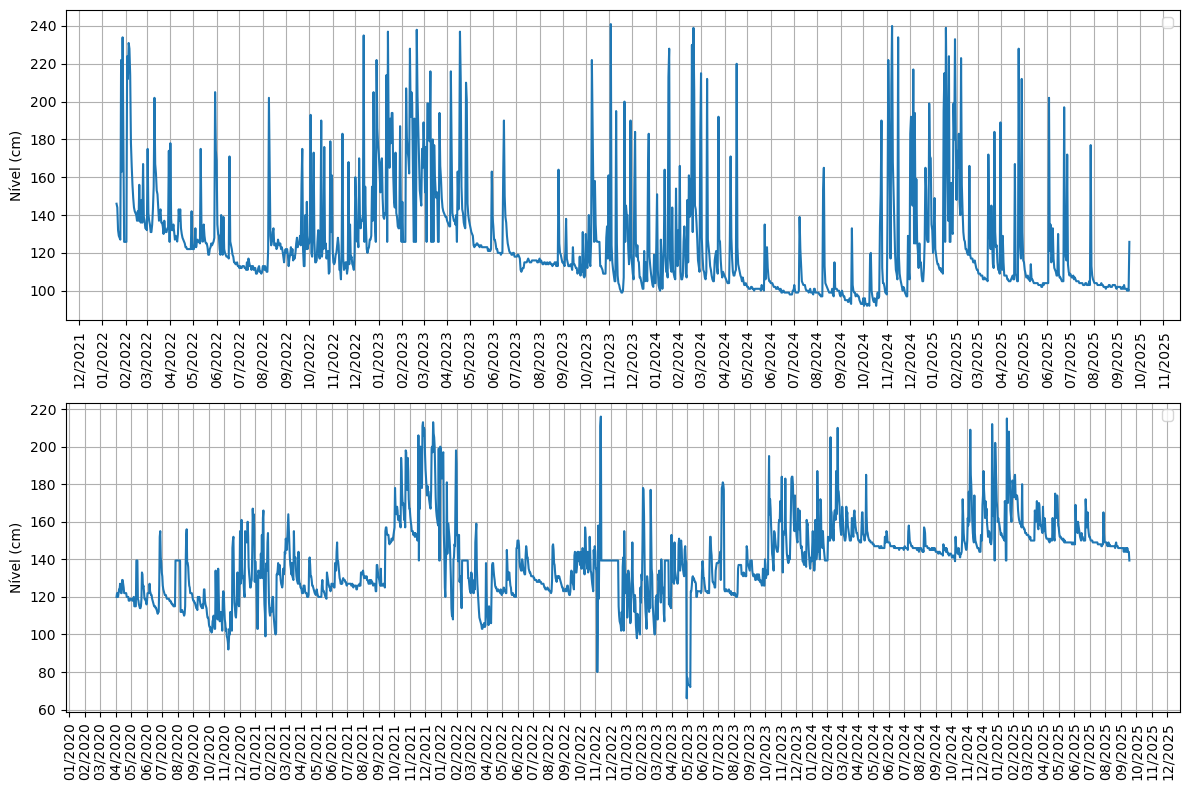

In [19]:
plot_series(df_jus_filt, df_mon_filt)

## Análise de Lags


In [20]:

def plot_acf_pacf(serie, lags=40):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(serie, lags=lags, ax=axes[0])
    plot_pacf(serie, lags=lags, ax=axes[1])
    axes[0].set_title('ACF')
    axes[1].set_title('PACF')
    plt.tight_layout()
    plt.show()


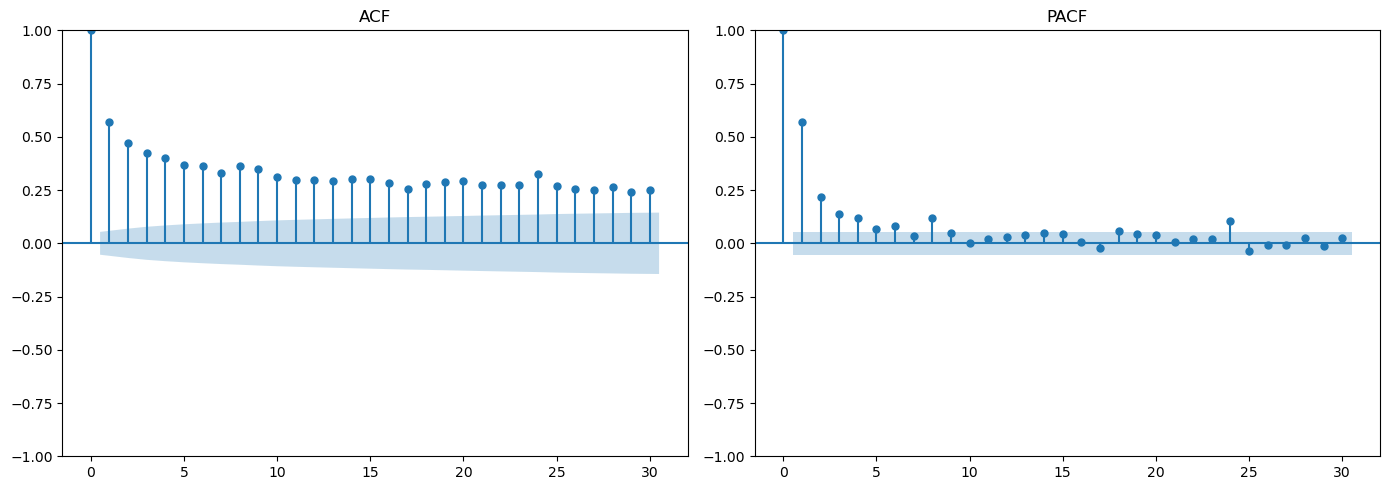

In [28]:
plot_acf_pacf(df_jus_filt['Nível (cm)'], lags=30)

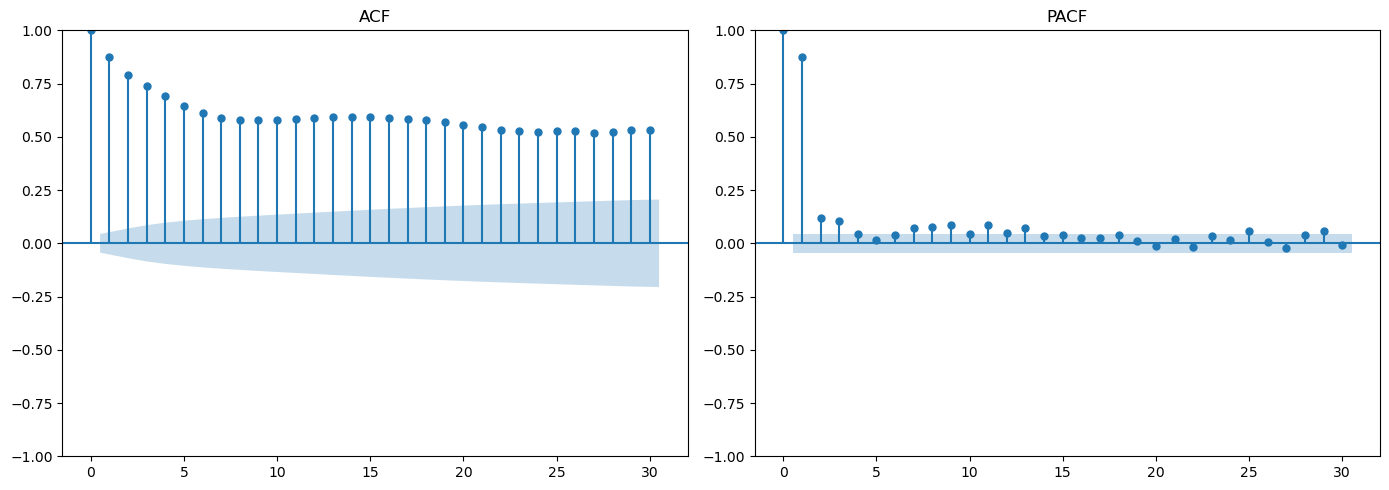

In [29]:
plot_acf_pacf(df_mon_filt['Nível (cm)'], lags=30)

# Decomposição das Séries

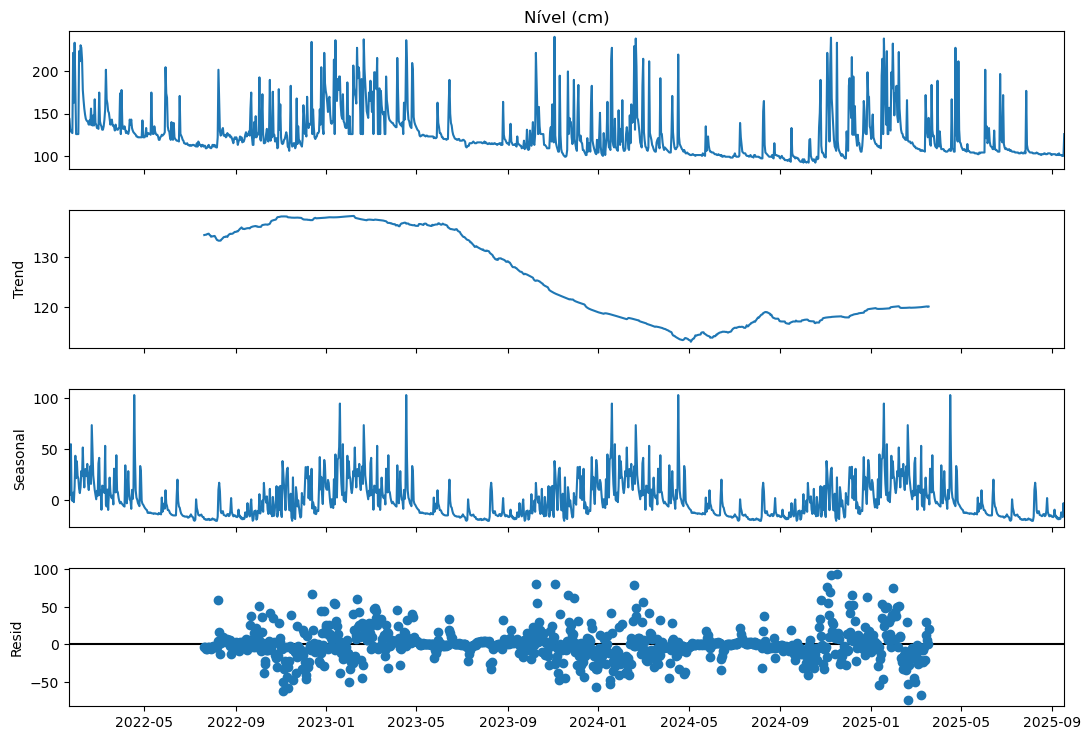

In [31]:
result = seasonal_decompose(df_jus_filt['Nível (cm)'], model='additive', period=365)

# Plot
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()

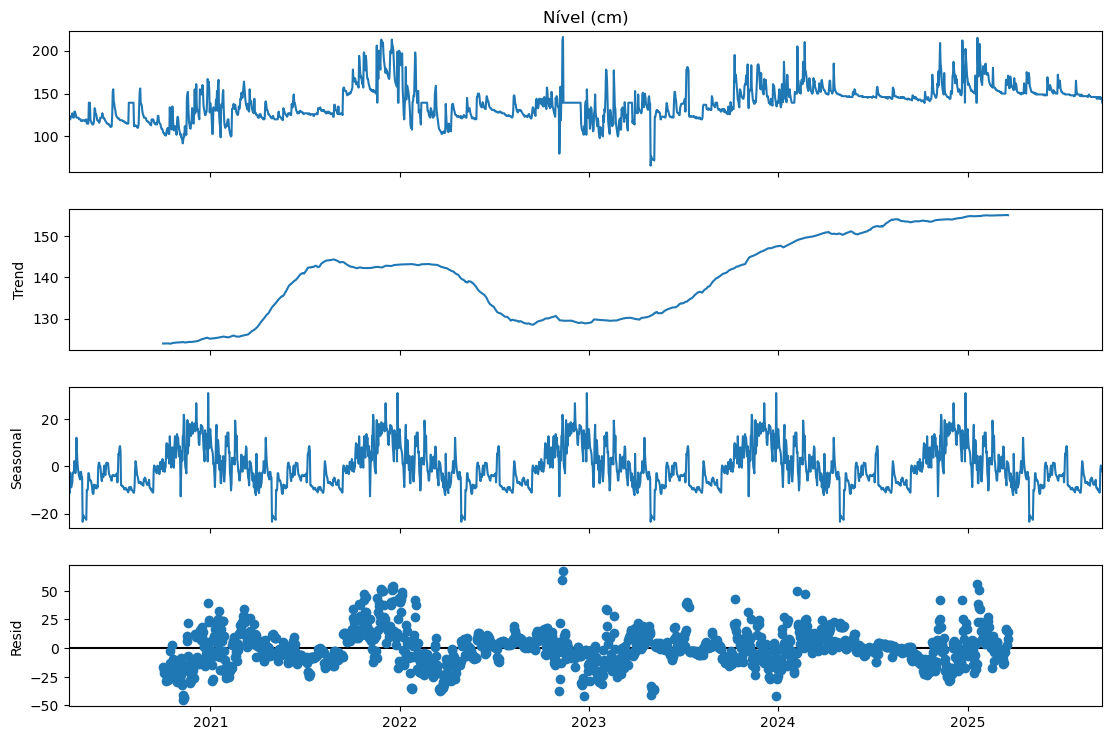

In [32]:
result = seasonal_decompose(df_mon_filt['Nível (cm)'], model='additive', period=365)

# Plot
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()

### Analise se Sazonalidade com FFT

In [33]:


def fft_analise(serie):
    
    serie_values = serie.values
    N = len(serie_values)
    T = 1  # intervalo de amostragem (ex: 1 hora, 1 dia, etc.)
    
    # FFT
    fft_values = np.fft.fft(serie_values)
    fft_freq = np.fft.fftfreq(N, d=T)
    
    # Apenas frequências positivas
    mask = fft_freq > 0
    freqs = fft_freq[mask]
    magnitudes = np.abs(fft_values[mask])
    periods = 1 / freqs
    
    # Detectar picos relevantes
    peaks, _ = find_peaks(magnitudes, height=np.mean(magnitudes) * 2)
    
    # Selecionar os 3 maiores picos
    top_peaks = peaks[np.argsort(magnitudes[peaks])[-3:]]
    
    # Plot
    plt.figure(figsize=(12, 6))
    #plt.plot(periods, magnitudes, lw=1)
    plt.stem(periods, magnitudes)
    plt.xscale('log')
    plt.xlabel('Período (unidades de tempo)')
    plt.ylabel('Magnitude')
    plt.title('FFT da série temporal — principais sazonalidades destacadas')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    
    # Destacar os principais picos
    for peak in top_peaks:
        period = periods[peak]
        magnitude = magnitudes[peak]
        plt.scatter(period, magnitude, color='red', s=60, zorder=5)
        plt.text(period, magnitude * 1.05, f'{int(period)}', 
                 color='red', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar os períodos dominantes no console
    dominant_periods = [int(periods[i]) for i in top_peaks]
    print("Principais períodos detectados:", dominant_periods)


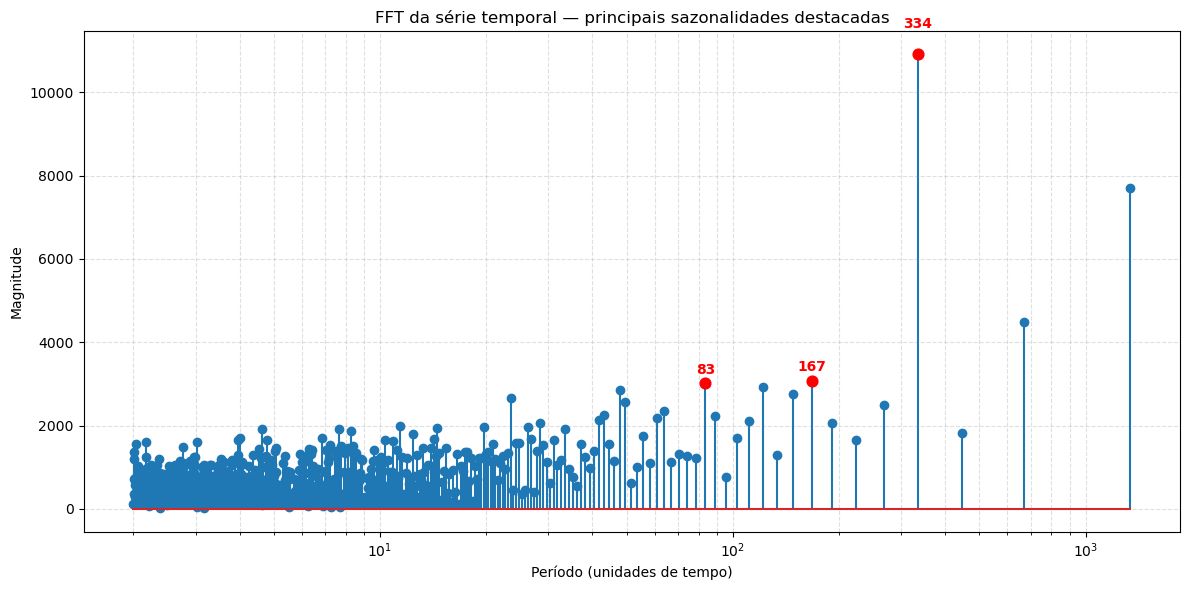

Principais períodos detectados: [83, 167, 334]


In [34]:
fft_analise(df_jus_filt['Nível (cm)'])

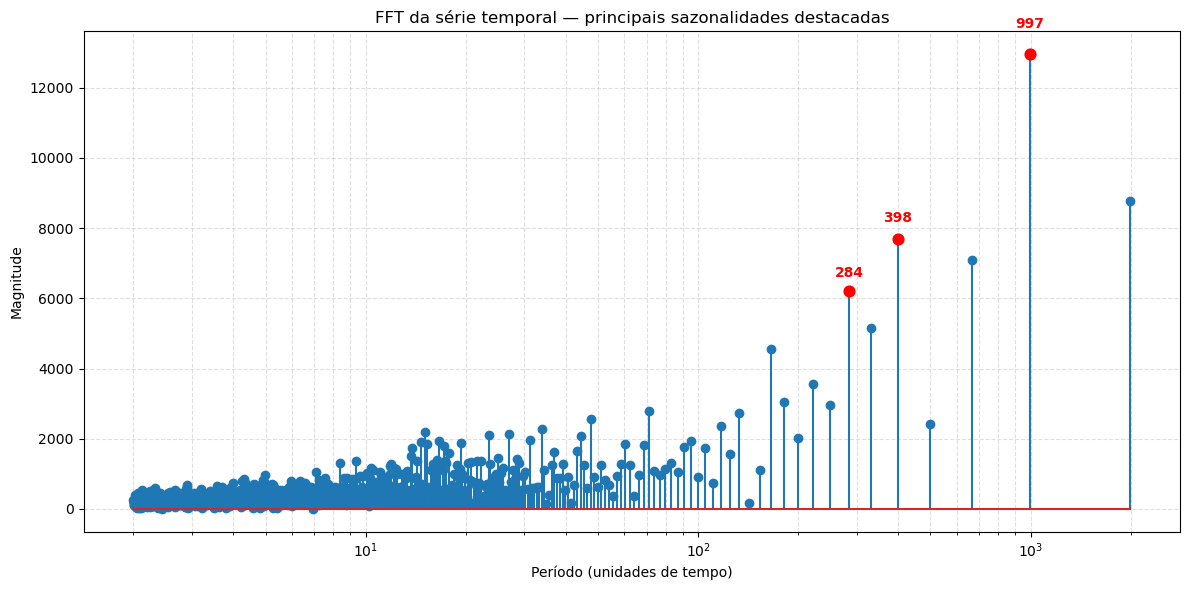

Principais períodos detectados: [284, 398, 997]


In [35]:
fft_analise(df_mon_filt['Nível (cm)'])

# Teste Arima

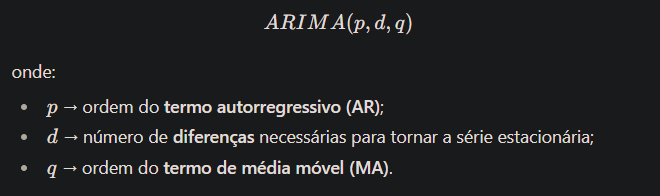

In [36]:
def teste_ADF(serie):
    
    # Teste ADF na série original
    adf_original = adfuller(serie.dropna())
    print("ADF (série original)")
    print(f"Estatística: {adf_original[0]:.4f}")
    print(f"p-valor: {adf_original[1]:.4f}")
    
    # Teste ADF após diferenciação de ordem 1
    serie_diff = serie.diff().dropna()
    adf_diff = adfuller(serie_diff)
    print("\nADF (série diferenciada)")
    print(f"Estatística: {adf_diff[0]:.4f}")
    print(f"p-valor: {adf_diff[1]:.4f}")
    
    # Teste ADF após diferenciação de ordem 2
    serie_diff2 = serie.diff().diff().dropna()
    adf_diff2 = adfuller(serie_diff2)
    print("\nADF (série diferenciada de ordem 2)")
    print(f"Estatística: {adf_diff2[0]:.4f}")
    print(f"p-valor: {adf_diff2[1]:.4f}")

In [37]:
def train_test_arima(serie, order=(1,1,0)):
        
    #train = serie.iloc[:-168]
    #test = serie.iloc[-168:]
    train = serie.iloc[:-7]
    test = serie.iloc[-7:]
    
    # Ajustar ARIMA no treino
    modelo = ARIMA(train, order=order)
    resultado = modelo.fit(cov_type='robust')
    print(resultado.summary())
    
    forecast = resultado.get_forecast(steps=7)
    pred = forecast.predicted_mean
    ic = forecast.conf_int()
    
    # Comparação
    plt.figure(figsize=(12,6))
    #plt.plot(train.index, train, label='Treino')
    plt.plot(test.index, test, label='Teste (Real)', color='black')
    plt.plot(test.index, pred, label='Previsão', color='green')
    plt.fill_between(test.index, ic.iloc[:,0], ic.iloc[:,1], 
                     color='gray', alpha=0.3, label='Intervalo Conf.')
    #plt.ylim(100.10, 100.30)
    plt.legend()
    plt.show()
    
    rmse = np.sqrt(mean_squared_error(test, pred))
    mae = mean_absolute_error(test, pred)
    erro_max = np.max(np.abs(test - pred))
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Erro máximo: {erro_max:.2f}")
    return forecast, pred, resultado
    


In [38]:
def train_test_sarima(serie, order=(1,1,0), seasonal_order=(1,1,1,24)):
        
    #train = serie.iloc[:-168]
    #test = serie.iloc[-168:]
    train = serie.iloc[:-7]
    test = serie.iloc[-7:]
    
    # Ajustar ARIMA no treino
    modelo = SARIMAX(
    train,
    order=order,                # parte não sazonal
    seasonal_order=seasonal_order,    # parte sazonal: (P,D,Q,m)
    enforce_stationarity=False,
    enforce_invertibility=False
)

    resultado = modelo.fit(cov_type='robust', approx_diffuse=True)
    print(resultado.summary())
    
    forecast = resultado.get_forecast(steps=7)
    pred = forecast.predicted_mean
    ic = forecast.conf_int()
    
    # Comparação
    plt.figure(figsize=(12,6))
    #plt.plot(train.index, train, label='Treino')
    plt.plot(test.index, test, label='Teste (Real)', color='black')
    plt.plot(test.index, pred, label='Previsão', color='green')
    plt.fill_between(test.index, ic.iloc[:,0], ic.iloc[:,1], 
                     color='gray', alpha=0.3, label='Intervalo Conf.')
    #plt.ylim(100.10, 100.30)
    plt.legend()
    plt.show()
    
    rmse = np.sqrt(mean_squared_error(test, pred))
    mae = mean_absolute_error(test, pred)
    erro_max = np.max(np.abs(test - pred))
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Erro máximo: {erro_max:.2f}")
    return forecast, pred
    


In [39]:
import pmdarima as pm

def select_arima(serie):
    train = serie[:len(serie)//2]
    modelo_auto = pm.auto_arima(
    serie,
    seasonal=True,
    m=24,              # ciclo de 24h
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    max_P=2, max_Q=2,
    d=None, D=None,    # estima automaticamente o número de diferenciações
    stepwise=True,     # busca heurística rápida
    trace=True,
    suppress_warnings=True
)
       
    print(modelo_auto.summary())



    

### Teste Jusante

In [33]:
teste_ADF(df_jus_filt['Nível (cm)'])

ADF (série original)
Estatística: -3.4368
p-valor: 0.0098

ADF (série diferenciada)
Estatística: -12.9287
p-valor: 0.0000

ADF (série diferenciada de ordem 2)
Estatística: -15.9455
p-valor: 0.0000


### Testes empíricos ARIMA jusante

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                ARIMA(4, 0, 10)   Log Likelihood               -6000.518
Date:                Wed, 22 Oct 2025   AIC                          12033.037
Time:                        01:11:14   BIC                          12116.124
Sample:                    01-20-2022   HQIC                         12064.176
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9405     12.326     10.217      0.000     101.782     150.099
ar.L1          0.9013      0.104      8.652      0.000       0.697       1.106
ar.L2         -0.0045      0.181     -0.025      0.9

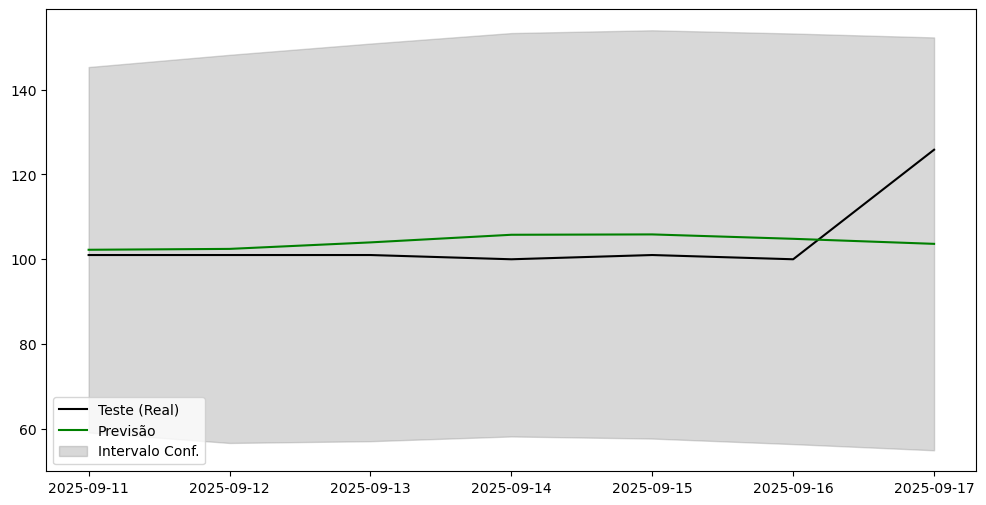

RMSE: 9.14
MAE: 6.19
Erro máximo: 22.18


In [46]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(4,0,10))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6086.913
Date:                Sat, 08 Nov 2025   AIC                          12179.825
Time:                        17:02:38   BIC                          12195.404
Sample:                    01-20-2022   HQIC                         12185.664
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9316      1.493     84.366      0.000     123.006     128.857
ar.L1          0.5688      0.030     19.240      0.000       0.511       0.627
sigma2       553.0457     45.098     12.263      0.0

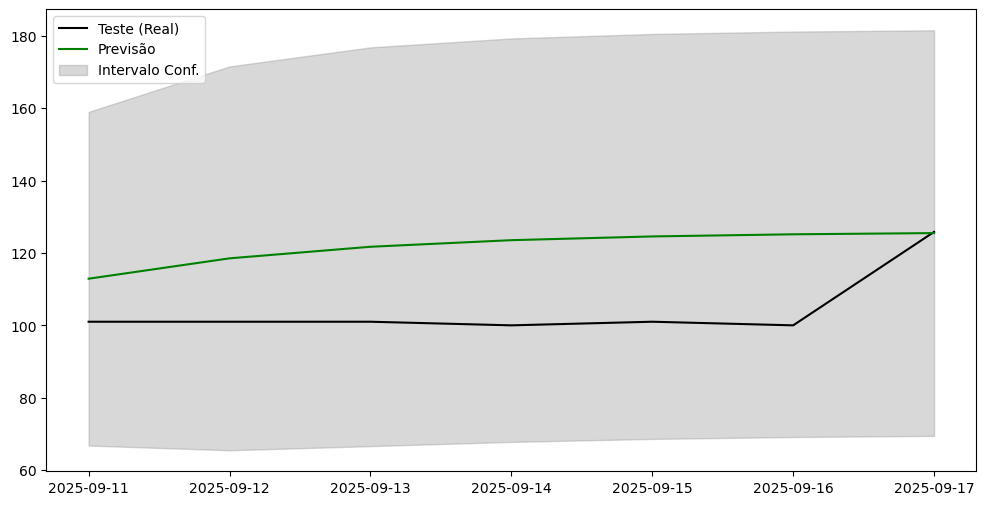

RMSE: 19.34
MAE: 17.53
Erro máximo: 25.15


In [40]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(1,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -6055.021
Date:                Sat, 08 Nov 2025   AIC                          12118.042
Time:                        17:04:54   BIC                          12138.813
Sample:                    01-20-2022   HQIC                         12125.826
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9316      1.857     67.833      0.000     122.293     129.570
ar.L1          0.4458      0.038     11.611      0.000       0.371       0.521
ar.L2          0.2163      0.039      5.575      0.0

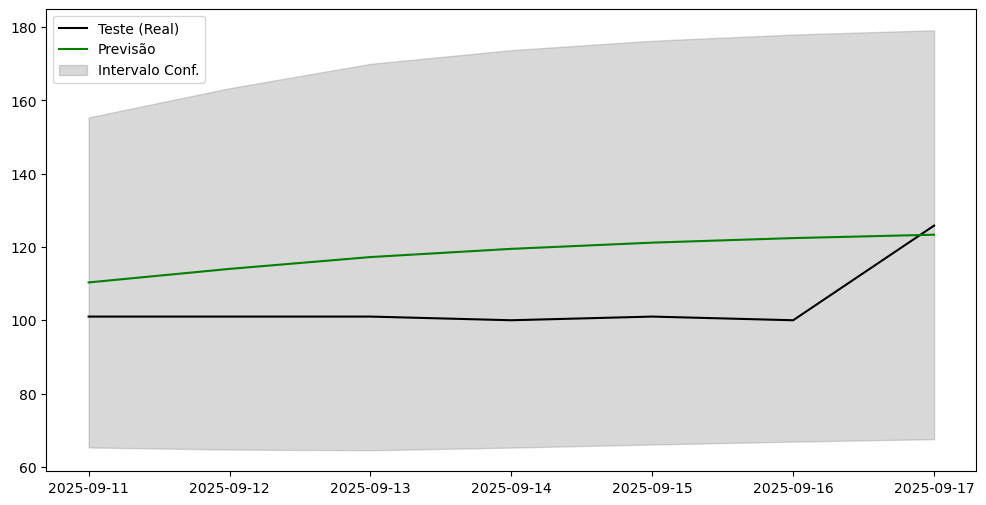

RMSE: 16.10
MAE: 14.73
Erro máximo: 22.41


In [41]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(2,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -6042.573
Date:                Sat, 08 Nov 2025   AIC                          12095.145
Time:                        17:05:43   BIC                          12121.110
Sample:                    01-20-2022   HQIC                         12104.876
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9309      2.125     59.268      0.000     121.766     130.095
ar.L1          0.4163      0.039     10.665      0.000       0.340       0.493
ar.L2          0.1557      0.041      3.820      0.0

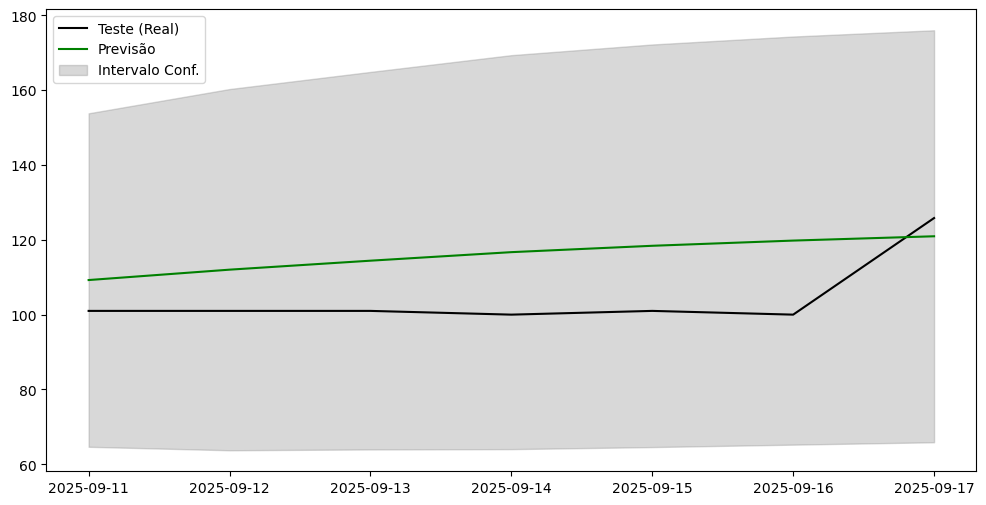

RMSE: 13.97
MAE: 13.07
Erro máximo: 19.79


In [42]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(3,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -6033.286
Date:                Sat, 08 Nov 2025   AIC                          12078.572
Time:                        17:06:26   BIC                          12109.730
Sample:                    01-20-2022   HQIC                         12090.249
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9305      2.386     52.783      0.000     121.254     130.607
ar.L1          0.4002      0.039     10.241      0.000       0.324       0.477
ar.L2          0.1374      0.041      3.351      0.0

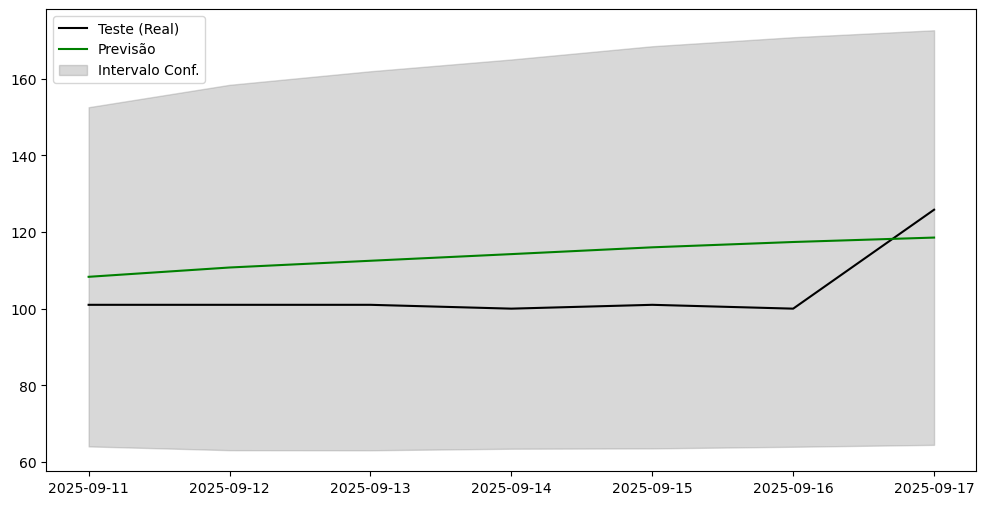

RMSE: 12.33
MAE: 11.78
Erro máximo: 17.39


In [43]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(4,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -6030.378
Date:                Sat, 08 Nov 2025   AIC                          12074.755
Time:                        17:08:20   BIC                          12111.106
Sample:                    01-20-2022   HQIC                         12088.379
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9303      2.544     49.502      0.000     120.944     130.916
ar.L1          0.3924      0.039     10.001      0.000       0.316       0.469
ar.L2          0.1316      0.041      3.191      0.0

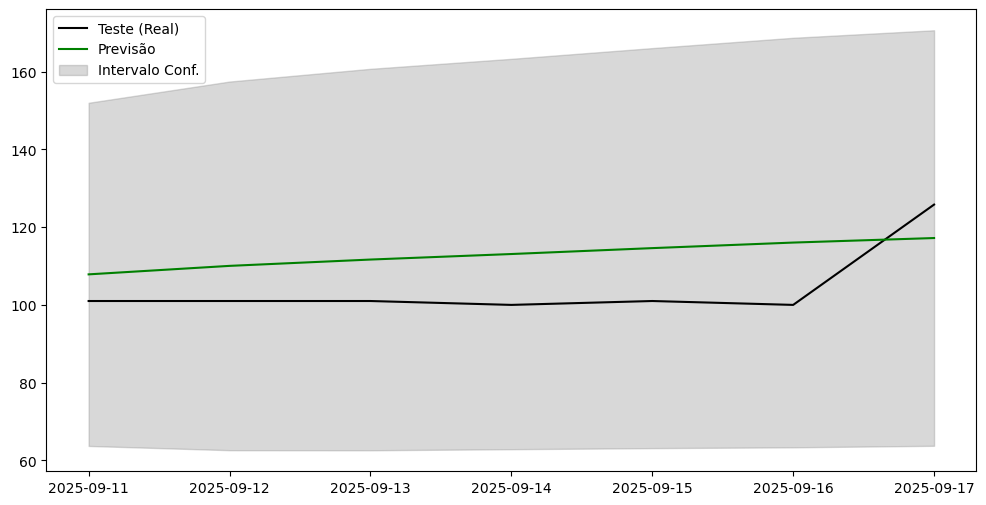

RMSE: 11.53
MAE: 11.13
Erro máximo: 16.04


In [44]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(5,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -6026.066
Date:                Sat, 08 Nov 2025   AIC                          12068.133
Time:                        17:08:45   BIC                          12109.676
Sample:                    01-20-2022   HQIC                         12083.702
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9300      2.750     45.789      0.000     120.540     131.320
ar.L1          0.3871      0.039      9.910      0.000       0.311       0.464
ar.L2          0.1243      0.041      3.006      0.0

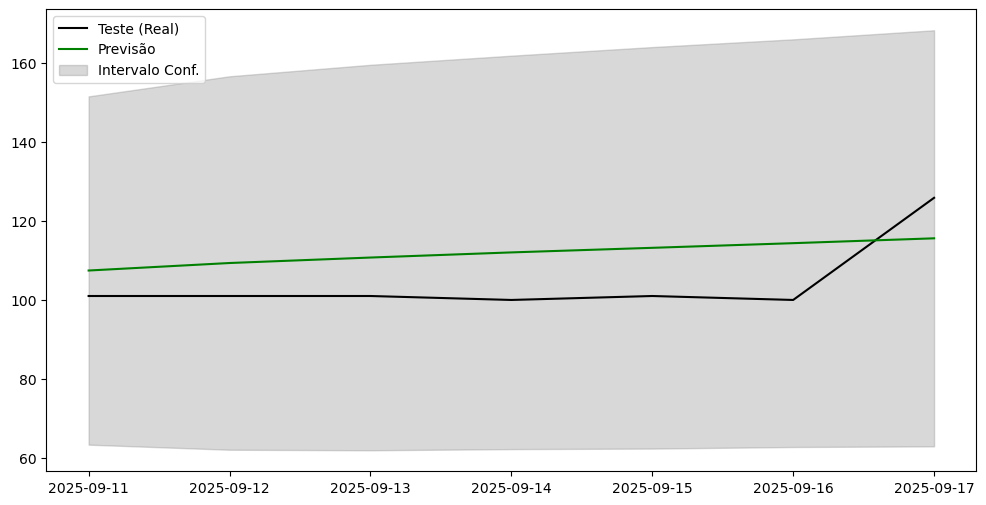

RMSE: 10.75
MAE: 10.47
Erro máximo: 14.35


In [45]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(6,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -6025.244
Date:                Sat, 08 Nov 2025   AIC                          12068.487
Time:                        17:09:33   BIC                          12115.224
Sample:                    01-20-2022   HQIC                         12086.003
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9301      2.849     44.209      0.000     120.347     131.513
ar.L1          0.3842      0.039      9.826      0.000       0.308       0.461
ar.L2          0.1231      0.041      2.969      0.0

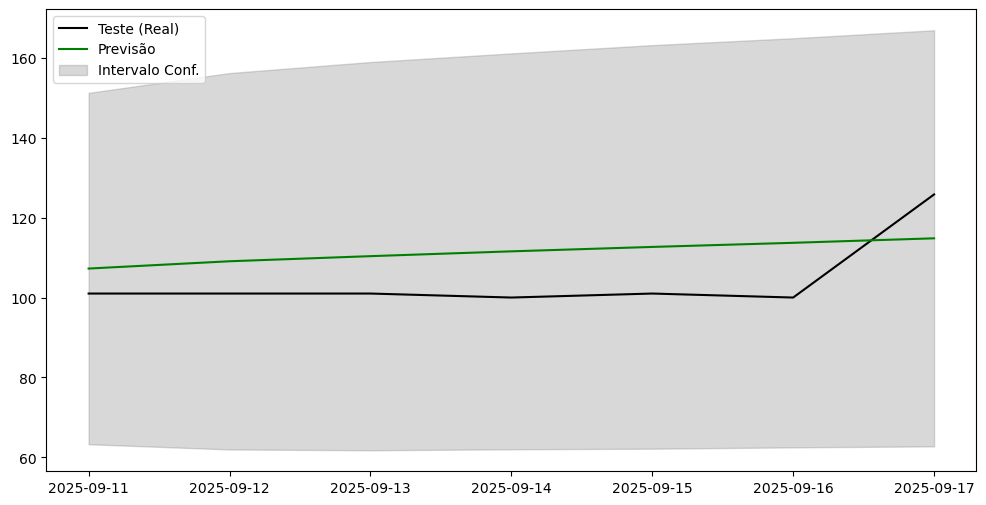

RMSE: 10.49
MAE: 10.23
Erro máximo: 13.70


In [46]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(7,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(8, 0, 0)   Log Likelihood               -6015.879
Date:                Sat, 08 Nov 2025   AIC                          12051.757
Time:                        17:09:58   BIC                          12103.686
Sample:                    01-20-2022   HQIC                         12071.219
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9305      3.198     39.375      0.000     119.662     132.199
ar.L1          0.3801      0.039      9.684      0.000       0.303       0.457
ar.L2          0.1153      0.041      2.806      0.0

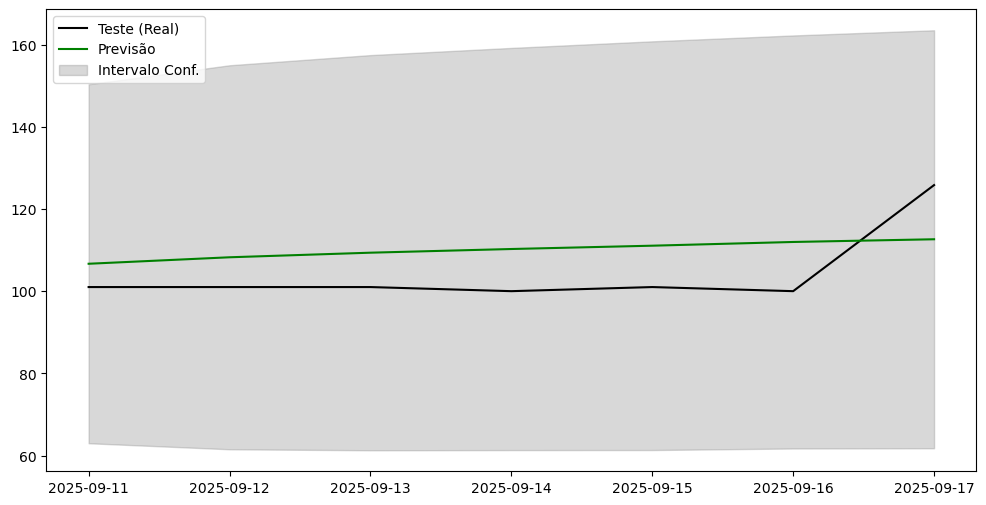

RMSE: 9.85
MAE: 9.54
Erro máximo: 13.19


In [47]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(8,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -6017.761
Date:                Sat, 08 Nov 2025   AIC                          12045.521
Time:                        17:30:54   BIC                          12071.486
Sample:                    01-20-2022   HQIC                         12055.252
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9305      4.192     30.044      0.000     117.715     134.146
ar.L1          0.9683      0.011     92.110      0.000       0.948       0.989
ma.L1         -0.6145      0.041    -14.945      0.0

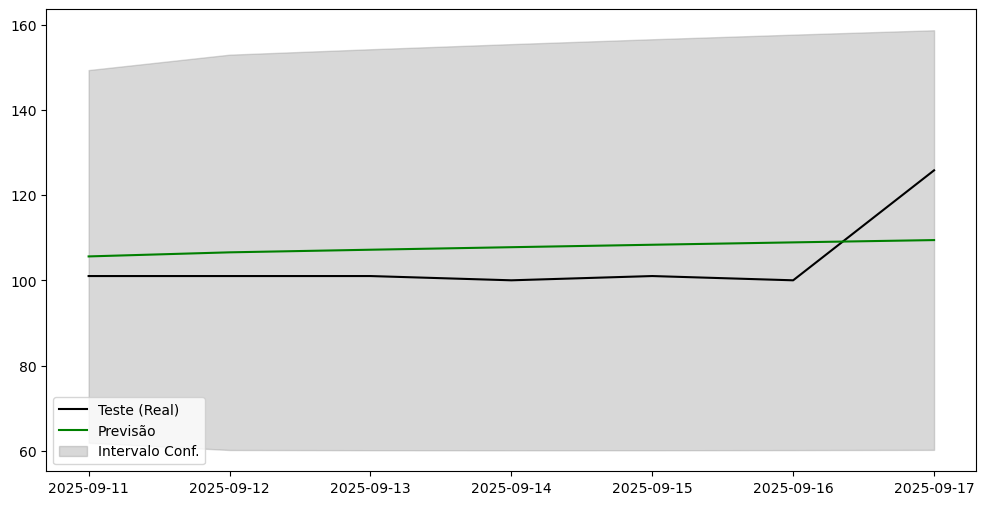

RMSE: 8.88
MAE: 8.11
Erro máximo: 16.38


In [52]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(1,0,2))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -6012.916
Date:                Sat, 08 Nov 2025   AIC                          12035.833
Time:                        17:32:53   BIC                          12061.798
Sample:                    01-20-2022   HQIC                         12045.564
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9359      5.750     21.902      0.000     114.666     137.206
ar.L1          1.2749      0.046     27.878      0.000       1.185       1.365
ar.L2         -0.2852      0.044     -6.476      0.0

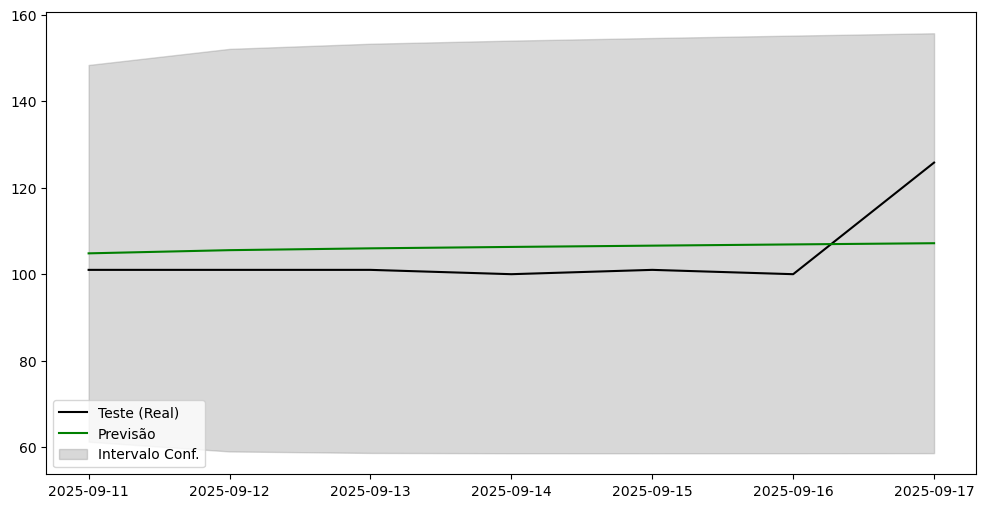

RMSE: 8.67
MAE: 7.26
Erro máximo: 18.65


In [56]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(2,0,1))

### Melhor modelo

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:                 ARIMA(8, 0, 0)   Log Likelihood               -6015.879
Date:                Sat, 08 Nov 2025   AIC                          12051.757
Time:                        18:03:34   BIC                          12103.686
Sample:                    01-20-2022   HQIC                         12071.219
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.9305      3.198     39.375      0.000     119.662     132.199
ar.L1          0.3801      0.039      9.684      0.000       0.303       0.457
ar.L2          0.1153      0.041      2.806      0.0

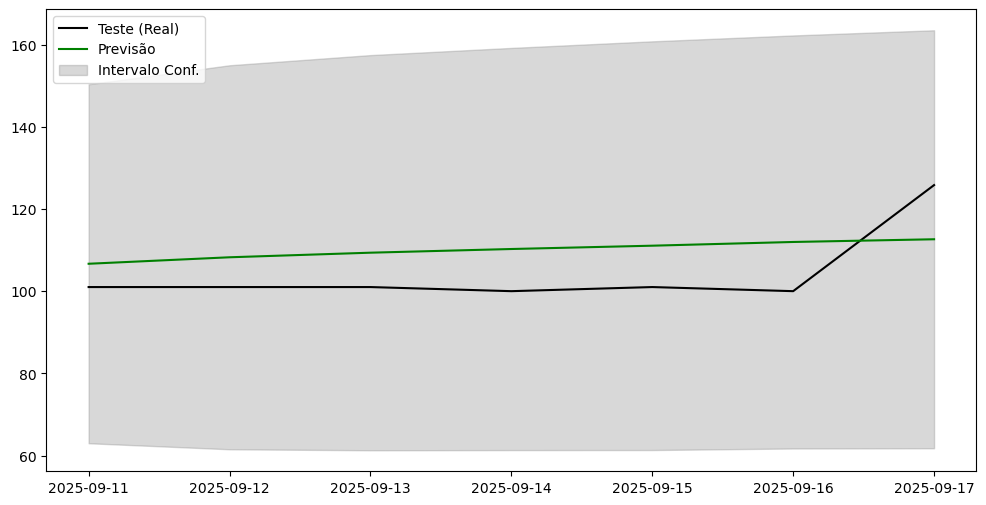

RMSE: 9.85
MAE: 9.54
Erro máximo: 13.19


In [69]:
forecast, pred, res = train_test_arima(df_jus_filt['Nível (cm)'], order=(8,0,0))

In [70]:
modelo_jus = "arima_jus.pkl"
with open(modelo_jus, "wb") as f:
    pickle.dump(res,f)

### Testes empíricos ARIMA montante

In [57]:
teste_ADF(df_mon_filt['Nível (cm)'])

ADF (série original)
Estatística: -3.9930
p-valor: 0.0014

ADF (série diferenciada)
Estatística: -13.3968
p-valor: 0.0000

ADF (série diferenciada de ordem 2)
Estatística: -18.5775
p-valor: 0.0000


                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1987
Model:                 ARIMA(1, 0, 7)   Log Likelihood               -7284.471
Date:                Sat, 08 Nov 2025   AIC                          14588.942
Time:                        17:50:10   BIC                          14644.886
Sample:                    04-03-2020   HQIC                         14609.490
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.2400      5.568     25.006      0.000     128.326     150.154
ar.L1          0.9928      0.004    247.982      0.000       0.985       1.001
ma.L1         -0.2811      0.041     -6.787      0.0

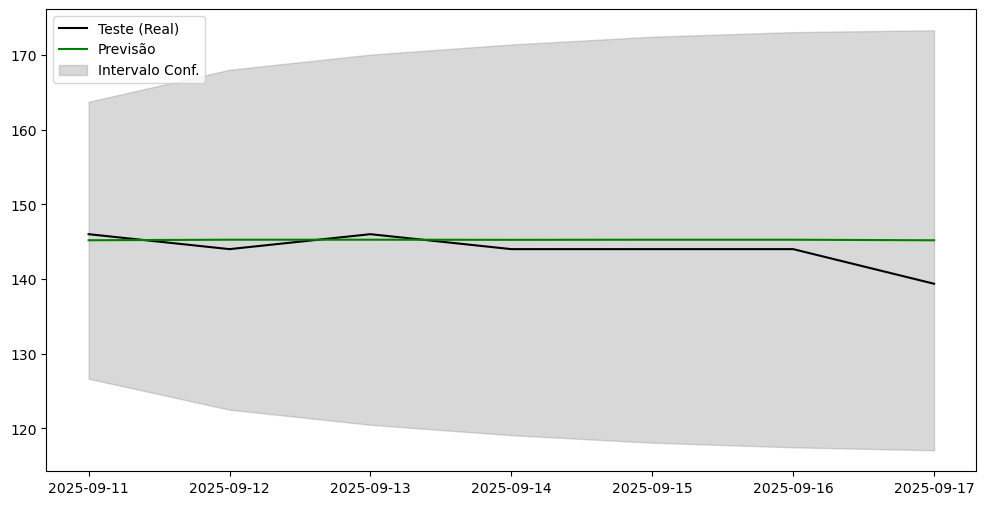

RMSE: 2.43
MAE: 1.77
Erro máximo: 5.82


In [58]:
forecast, pred, res = train_test_arima(df_mon_filt['Nível (cm)'], order=(1,0,7))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1987
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7351.277
Date:                Sat, 08 Nov 2025   AIC                          14708.555
Time:                        17:51:33   BIC                          14725.338
Sample:                    04-03-2020   HQIC                         14714.719
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.3495      1.727     80.704      0.000     135.965     142.734
ar.L1          0.8734      0.016     54.521      0.000       0.842       0.905
sigma2        95.6591      8.727     10.961      0.0

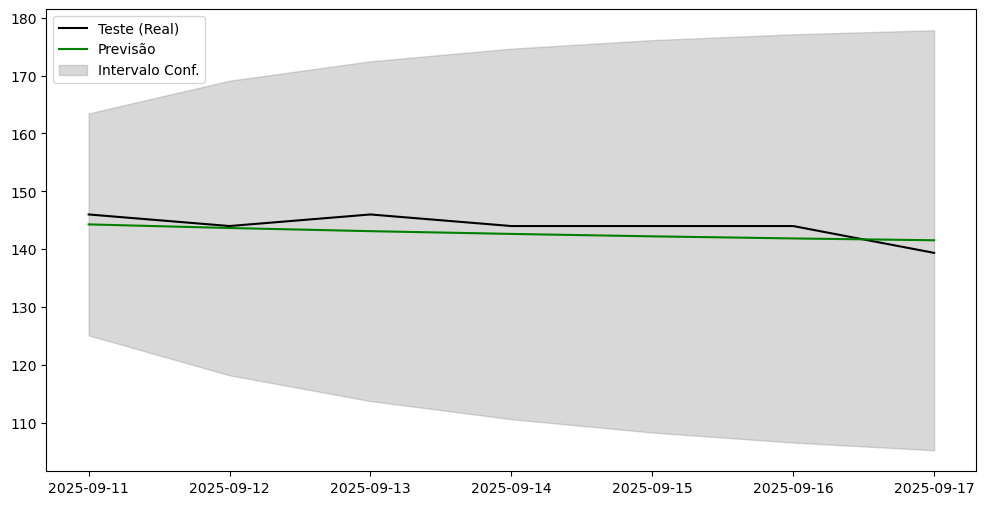

RMSE: 1.92
MAE: 1.77
Erro máximo: 2.89


In [59]:
forecast, pred, res = train_test_arima(df_mon_filt['Nível (cm)'], order=(1,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1987
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7337.482
Date:                Sat, 08 Nov 2025   AIC                          14682.964
Time:                        17:52:08   BIC                          14705.342
Sample:                    04-03-2020   HQIC                         14691.184
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.3496      1.940     71.828      0.000     135.547     143.152
ar.L1          0.7709      0.040     19.456      0.000       0.693       0.849
ar.L2          0.1174      0.038      3.098      0.0

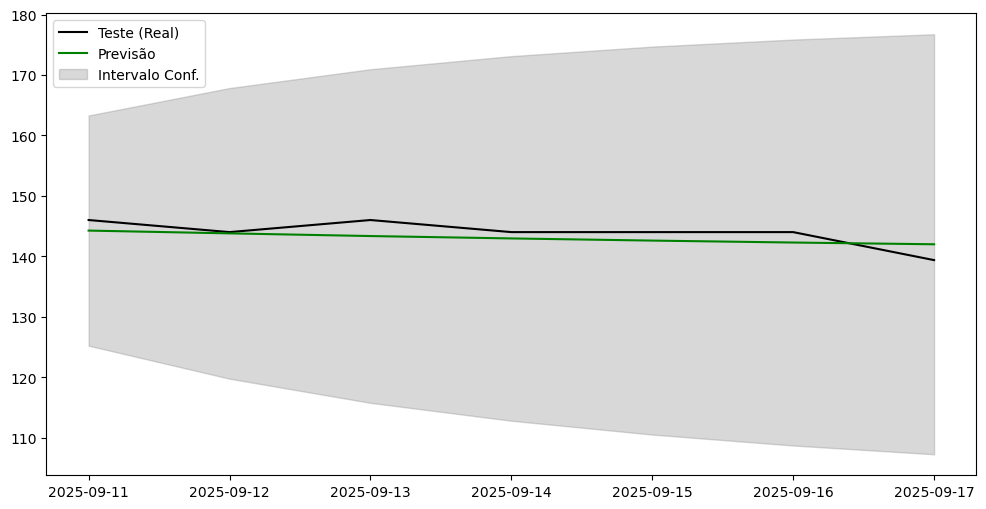

RMSE: 1.81
MAE: 1.63
Erro máximo: 2.65


In [60]:
forecast, pred, res = train_test_arima(df_mon_filt['Nível (cm)'], order=(2,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1987
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -7326.154
Date:                Sat, 08 Nov 2025   AIC                          14662.308
Time:                        17:52:49   BIC                          14690.280
Sample:                    04-03-2020   HQIC                         14672.582
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.3492      2.155     64.658      0.000     135.125     143.573
ar.L1          0.7583      0.040     19.011      0.000       0.680       0.837
ar.L2          0.0353      0.056      0.635      0.5

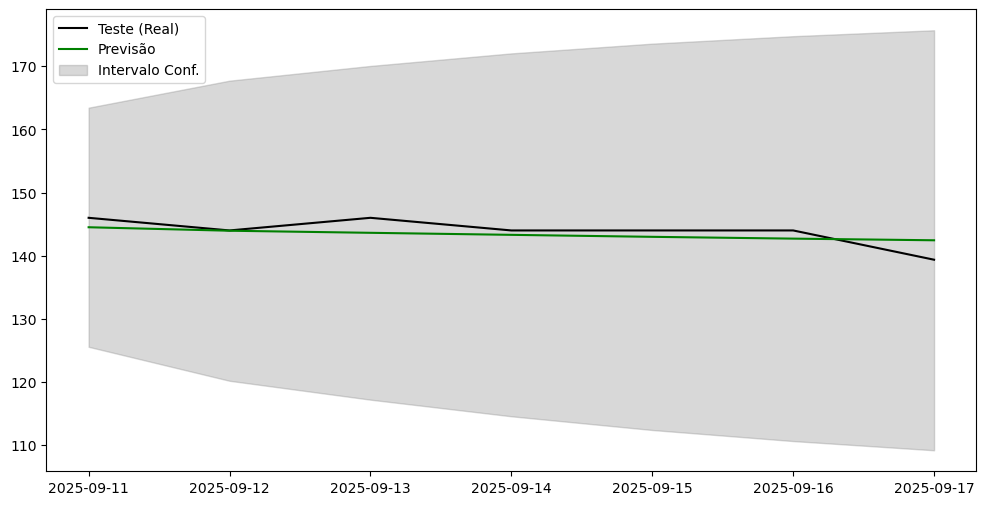

RMSE: 1.71
MAE: 1.43
Erro máximo: 3.08


In [62]:
forecast, pred, res = train_test_arima(df_mon_filt['Nível (cm)'], order=(3,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1987
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -7324.142
Date:                Sat, 08 Nov 2025   AIC                          14660.284
Time:                        17:53:17   BIC                          14693.850
Sample:                    04-03-2020   HQIC                         14672.613
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.3491      2.253     61.851      0.000     134.933     143.765
ar.L1          0.7535      0.040     18.682      0.000       0.674       0.833
ar.L2          0.0338      0.055      0.610      0.5

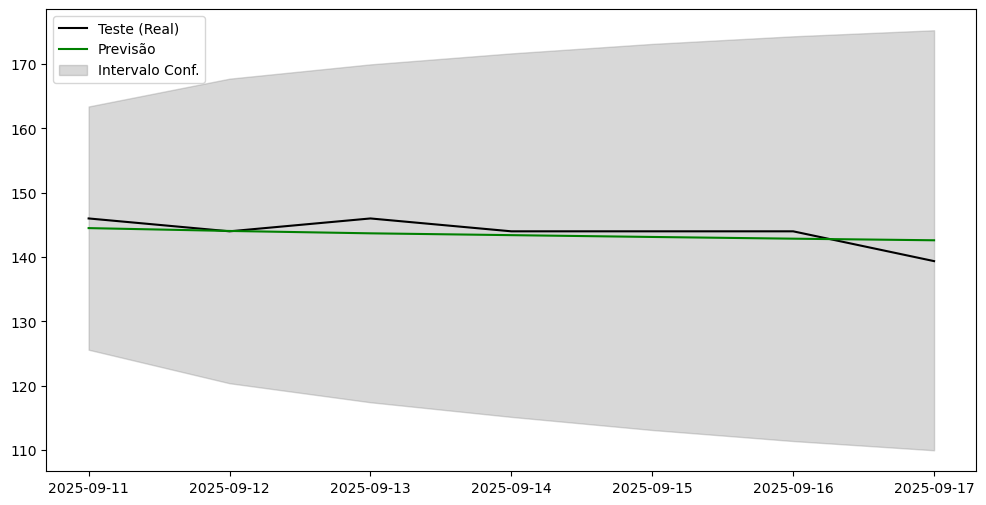

RMSE: 1.71
MAE: 1.39
Erro máximo: 3.24


In [64]:
forecast, pred, res = train_test_arima(df_mon_filt['Nível (cm)'], order=(4,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1987
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -7323.915
Date:                Sat, 08 Nov 2025   AIC                          14661.831
Time:                        17:53:46   BIC                          14700.991
Sample:                    04-03-2020   HQIC                         14676.214
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.3492      2.286     60.970      0.000     134.870     143.829
ar.L1          0.7529      0.040     18.656      0.000       0.674       0.832
ar.L2          0.0327      0.056      0.586      0.5

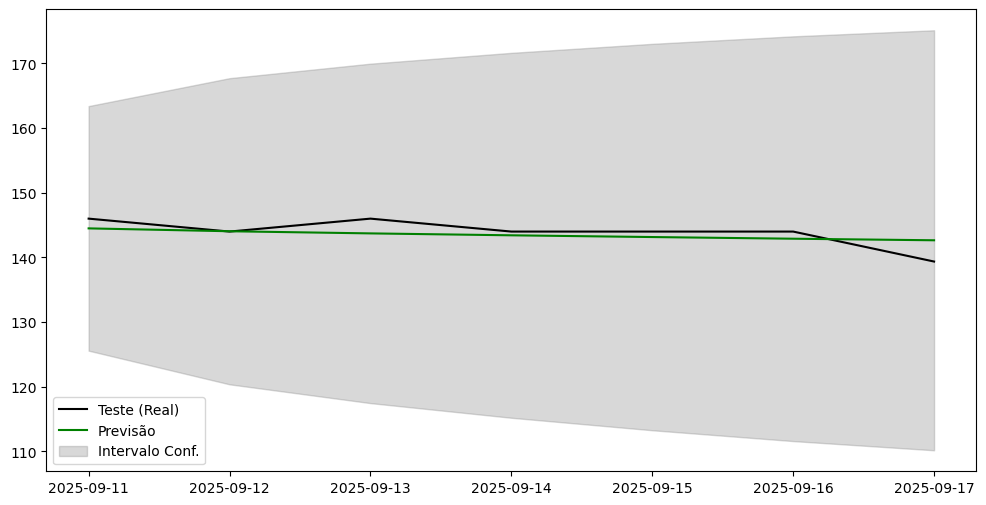

RMSE: 1.71
MAE: 1.38
Erro máximo: 3.29


In [65]:
forecast, pred, res = train_test_arima(df_mon_filt['Nível (cm)'], order=(5,0,0))

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1987
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7333.248
Date:                Sat, 08 Nov 2025   AIC                          14674.496
Time:                        17:55:03   BIC                          14696.874
Sample:                    04-03-2020   HQIC                         14682.715
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.3489      2.060     67.653      0.000     135.312     143.386
ar.L1          0.9134      0.013     70.261      0.000       0.888       0.939
ma.L1         -0.1751      0.042     -4.177      0.0

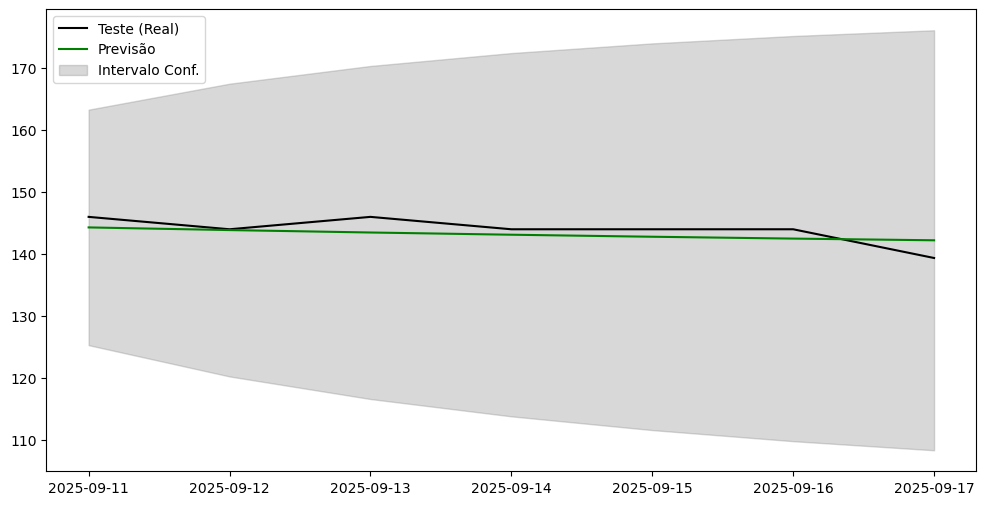

RMSE: 1.77
MAE: 1.54
Erro máximo: 2.86


In [66]:
forecast, pred, res = train_test_arima(df_mon_filt['Nível (cm)'], order=(1,0,1))

### Melhor modelo


                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1987
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7337.482
Date:                Sat, 08 Nov 2025   AIC                          14682.964
Time:                        18:06:59   BIC                          14705.342
Sample:                    04-03-2020   HQIC                         14691.184
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.3496      1.940     71.828      0.000     135.547     143.152
ar.L1          0.7709      0.040     19.456      0.000       0.693       0.849
ar.L2          0.1174      0.038      3.098      0.0

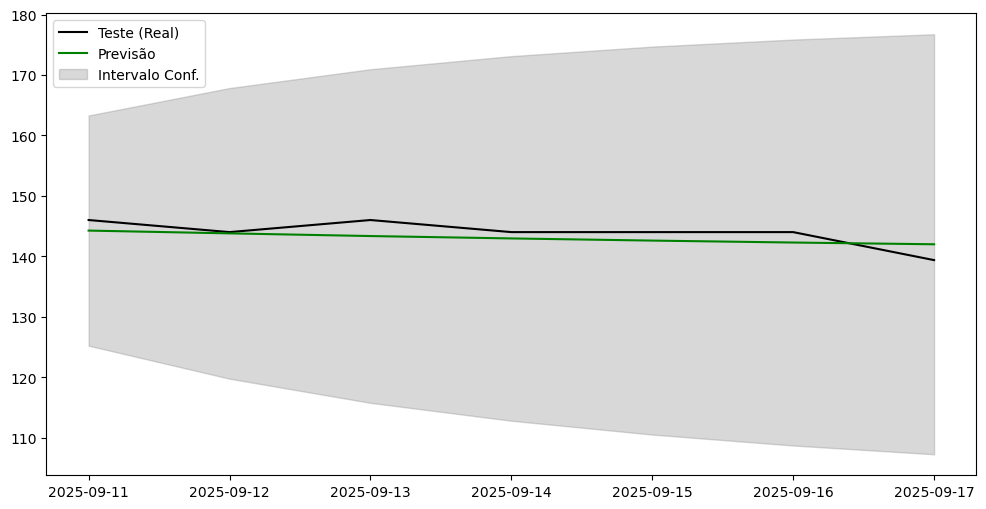

RMSE: 1.81
MAE: 1.63
Erro máximo: 2.65


In [71]:
forecast, pred, res = train_test_arima(df_mon_filt['Nível (cm)'], order=(2,0,0))

In [72]:
modelo_mon = "arima_mon.pkl"
with open(modelo_mon, "wb") as f:
    pickle.dump(res,f)

### Teste Jusante com Sazonalidade Anual

In [35]:


def train_test_sarima_fourier(serie, order=(1,1,1), n_harm=3):
    """
    Treina um modelo SARIMAX com termos de Fourier para capturar sazonalidade anual.
    - n_harm: número de harmônicos Fourier (3 é um bom ponto de partida)
    """

    # --- Divisão treino/teste ---
    train = serie.iloc[:-7]
    test = serie.iloc[-7:]

    # --- Criação dos termos de Fourier (sazonalidade anual) ---
    fourier = CalendarFourier(freq='A', order=n_harm)  # 'A' = anual
    dp = DeterministicProcess(
        index=serie.index,
        constant=True,
        order=1,  # tendência linear
        additional_terms=[fourier],
        drop=True
    )
    X = dp.in_sample()
    X_train, X_test = X.iloc[:-7], X.iloc[-7:]

    # --- Ajuste do modelo ---
    modelo = SARIMAX(
        train,
        order=order,
        exog=X_train,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultado = modelo.fit(disp=False)
    print(resultado.summary())

    # --- Previsão ---
    forecast = resultado.get_forecast(steps=7, exog=X_test)
    pred = forecast.predicted_mean
    ic = forecast.conf_int()

    # --- Gráfico ---
    plt.figure(figsize=(12,6))
    plt.plot(test.index, test, label='Teste (Real)', color='black')
    plt.plot(test.index, pred, label='Previsão', color='green')
    plt.fill_between(test.index, ic.iloc[:,0], ic.iloc[:,1], 
                     color='gray', alpha=0.3, label='Intervalo Conf.')
    #plt.ylim(99,110)
    plt.legend()
    plt.title('Previsão SARIMA com Fourier (Sazonalidade Anual)')
    plt.show()

    # --- Métricas ---
    rmse = np.sqrt(mean_squared_error(test, pred))
    mae = mean_absolute_error(test, pred)
    erro_max = np.max(np.abs(test - pred))

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Erro máximo: {erro_max:.2f}")

    return forecast, pred, resultado


C:\Users\ksilva\anaconda3\envs\weather_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:              SARIMAX(4, 0, 10)   Log Likelihood               -5929.349
Date:                Tue, 21 Oct 2025   AIC                          11900.699
Time:                        22:41:05   BIC                          12009.576
Sample:                    01-20-2022   HQIC                         11941.520
                         - 09-10-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                138.7881      9.225     15.045      0.000     120.707     156.869
trend                 -0.0185      0.010     -1.857      0.063      -0.038       0.001
sin(1,freq=YE-DEC)  

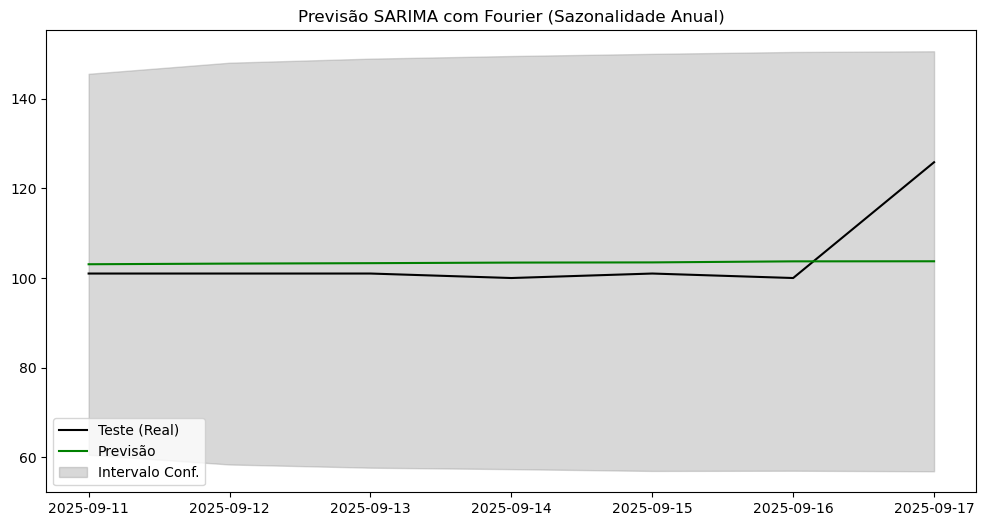

RMSE: 8.74
MAE: 5.48
Erro máximo: 22.09


In [36]:
forecast, pred, modelo = train_test_sarima_fourier(
    df_jus_filt['Nível (cm)'],
    order=(4,0,10),
    n_harm=2  # número de harmônicos anuais
)


In [37]:
pred

2025-09-11    103.072156
2025-09-12    103.215415
2025-09-13    103.311104
2025-09-14    103.442139
2025-09-15    103.483490
2025-09-16    103.716724
2025-09-17    103.733119
Freq: D, Name: predicted_mean, dtype: float64

C:\Users\ksilva\anaconda3\envs\weather_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:              SARIMAX(4, 0, 10)   Log Likelihood               -5930.910
Date:                Tue, 21 Oct 2025   AIC                          11899.821
Time:                        22:41:20   BIC                          11998.329
Sample:                    01-20-2022   HQIC                         11936.755
                         - 09-10-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                138.7798      8.682     15.984      0.000     121.763     155.797
trend                 -0.0186      0.009     -1.986      0.047      -0.037      -0.000
sin(1,freq=YE-DEC)  

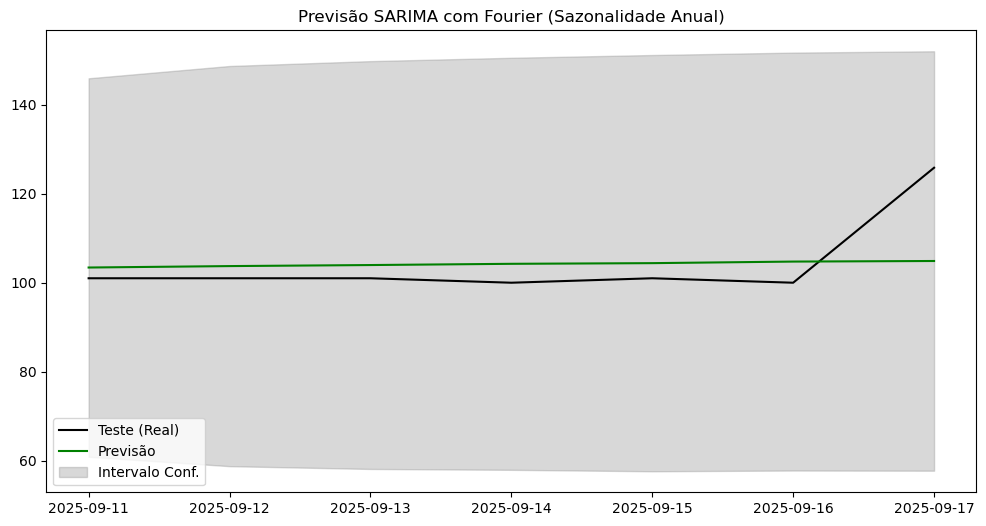

RMSE: 8.56
MAE: 5.92
Erro máximo: 20.94


In [38]:
forecast, pred, modelo = train_test_sarima_fourier(
    df_jus_filt['Nível (cm)'],
    order=(4,0,10),
    n_harm=1  # número de harmônicos anuais
)


In [94]:
pred

2025-09-11    103.412350
2025-09-12    103.734540
2025-09-13    103.968602
2025-09-14    104.246141
2025-09-15    104.394701
2025-09-16    104.747696
2025-09-17    104.877664
Freq: D, Name: predicted_mean, dtype: float64

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:              SARIMAX(4, 0, 10)   Log Likelihood               -5928.302
Date:                Wed, 15 Oct 2025   AIC                          11902.605
Time:                        11:28:30   BIC                          12021.851
Sample:                    01-20-2022   HQIC                         11947.314
                         - 09-10-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                138.5642      9.562     14.490      0.000     119.822     157.306
trend                 -0.0182      0.010     -1.779      0.075      -0.038       0.002
sin(1,freq=YE-DEC)  

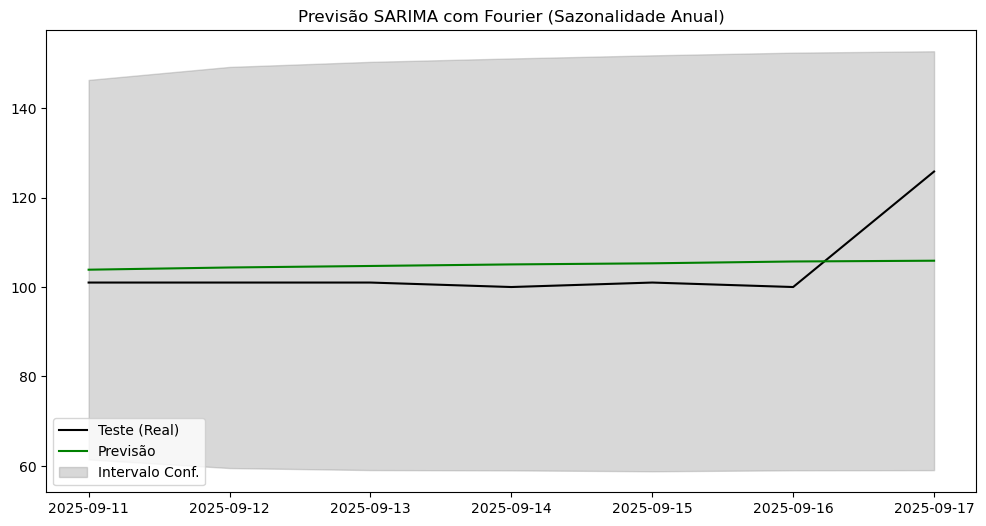

RMSE: 8.51
MAE: 6.42
Erro máximo: 19.94


In [95]:
forecast, pred, modelo = train_test_sarima_fourier(
    df_jus_filt['Nível (cm)'],
    order=(4,0,10),
    n_harm=3  # número de harmônicos anuais
)

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1330
Model:              SARIMAX(4, 0, 30)   Log Likelihood               -5820.614
Date:                Wed, 15 Oct 2025   AIC                          11727.227
Time:                        11:29:59   BIC                          11949.509
Sample:                    01-20-2022   HQIC                         11810.631
                         - 09-10-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                138.5747      9.165     15.120      0.000     120.611     156.538
trend                 -0.0182      0.010     -1.814      0.070      -0.038       0.001
sin(1,freq=YE-DEC)  

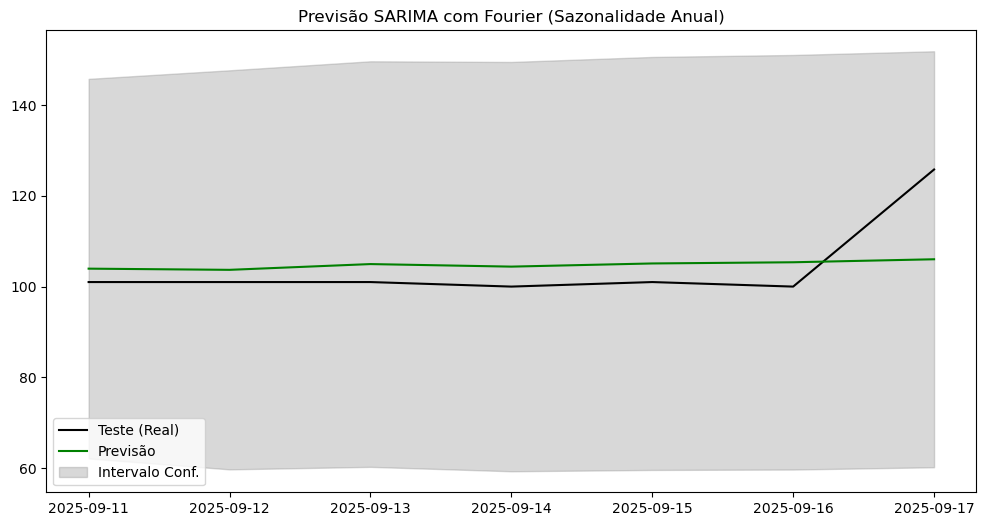

RMSE: 8.35
MAE: 6.18
Erro máximo: 19.79


In [96]:
forecast, pred, modelo = train_test_sarima_fourier(
    df_jus_filt['Nível (cm)'],
    order=(4,0,30),
    n_harm=3  # número de harmônicos anuais
)

In [97]:
pred

2025-09-11    103.955451
2025-09-12    103.693569
2025-09-13    104.964324
2025-09-14    104.403290
2025-09-15    105.101612
2025-09-16    105.364652
2025-09-17    106.025173
Freq: D, Name: predicted_mean, dtype: float64

A melhor configuração para o modelo de justante é a ordem 4,1,0 do ARIMA. Chama a atenção a heterocedasticidade. O que torna os intervalos de confiança menos confiáveis. Para mitigar este efeito foi definido o Covariance Type: robust.

### Teste Montante Sazonalidade Anual

                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                 1987
Model:               SARIMAX(1, 0, 7)   Log Likelihood               -7251.105
Date:                Wed, 15 Oct 2025   AIC                          14532.210
Time:                        11:41:54   BIC                          14616.065
Sample:                    04-03-2020   HQIC                         14563.016
                         - 09-10-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                123.1902      8.552     14.404      0.000     106.428     139.952
trend                  0.0164      0.007      2.229      0.026       0.002       0.031
sin(1,freq=YE-DEC)  

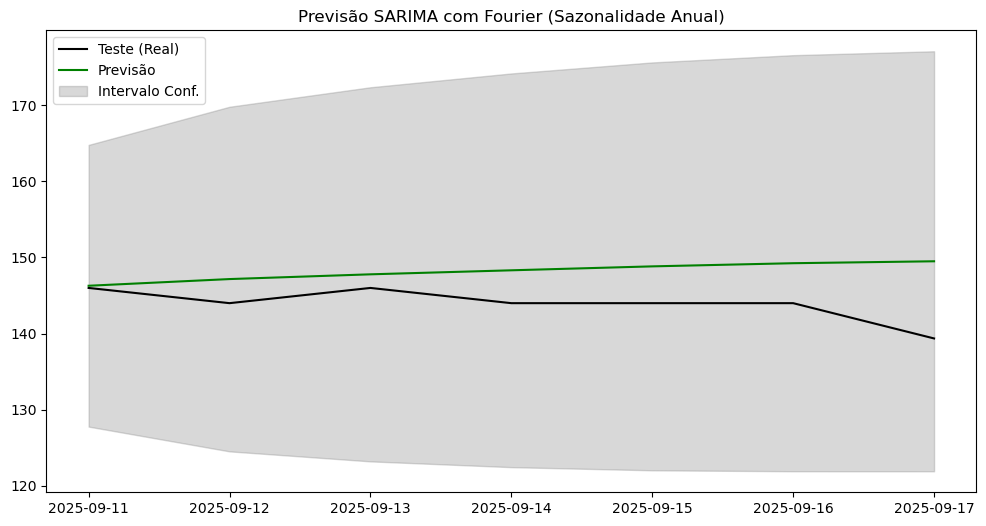

RMSE: 5.15
MAE: 4.25
Erro máximo: 10.14


In [101]:
forecast, pred, modelo = train_test_sarima_fourier(
    df_mon_filt['Nível (cm)'],
    order=(1,0,7),
    n_harm=2  # número de harmônicos anuais
)

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rolling_forecast_arima(serie, order=(1,1,0), steps=168, start=31904):
    """
    Faz previsões semanais (steps=168) com ARIMA, atualizando o modelo
    com os dados reais da semana prevista. 
    A última previsão pode ser menor que 'steps'.
    """
    
    resultados = []

    while start + steps < len(serie):
        # tamanho da janela de previsão (pode ser < steps na última iteração)
        horizon = min(steps, len(serie) - (start + steps))

        # definir treino e teste
        train = serie.iloc[:start+steps]
        test = serie.iloc[start+steps:start+steps+horizon]

        # treinar ARIMA
        modelo = ARIMA(train, order=order)
        resultado = modelo.fit(cov_type="robust")

        # forecast
        forecast = resultado.get_forecast(steps=horizon)
        pred = forecast.predicted_mean
        ic = forecast.conf_int()

        # plotar
        plt.figure(figsize=(12,6))
        plt.plot(test.index, test, label="Teste (Real)", color="black")
        plt.plot(test.index, pred, label="Previsão", color="green")
        plt.fill_between(test.index, ic.iloc[:,0], ic.iloc[:,1],
                         color="gray", alpha=0.3, label="Intervalo Conf.")
        plt.title(f"Previsão semana {start//steps + 1}")
        plt.legend()
        plt.show()

        # métricas
        rmse = np.sqrt(mean_squared_error(test, pred))
        mae = mean_absolute_error(test, pred)
        erro_max = np.max(np.abs(test - pred))

        print(f"Semana {start//steps + 1}:")
        print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, Erro Máx: {erro_max:.2f}\n")

        resultados.append({
            "semana": start//steps + 1,
            "rmse": rmse,
            "mae": mae,
            "erro_max": erro_max
        })

        # avançar janela
        start += steps

    return resultados


In [109]:
df_jus_test = pd.read_csv('Telemetria_Construserv_2025-10-01.csv', encoding='ISO-8859-1',
                 sep=';',skiprows=1, skipfooter=1, engine='python', decimal=',',
                na_values = '-', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0',
                dayfirst=True)

df_jus_test.index.name='timestamp'
df_jus_test.index = pd.to_datetime(df_jus_test.index, format="%d/%m/%Y %H:%M", dayfirst=True, errors='coerce')
#df_jus_test

In [110]:
df_mon_test = pd.read_csv('Telemetria_Construserv_2025-10-01_montante.csv', encoding='ISO-8859-1',
                 sep=';',skiprows=1, skipfooter=1, engine='python', decimal=',',
                na_values = '-', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0',
                dayfirst=True)

df_mon_test.index.name='timestamp'
df_mon_test.index = pd.to_datetime(df_mon_test.index, format="%d/%m/%Y %H:%M", dayfirst=True, errors='coerce')
#df_jus_test



In [117]:
df_mon_test = tratar_outliers_iqr(df_mon_test, 'Nível (cm)', q1=0.15, q3=0.85)
df_jus_test = tratar_outliers_iqr(df_jus_test, 'Nível (cm)', q1=0.15, q3=0.85)
df_mon_test = preencher_nans(df_mon_test, 'Nível (cm)')
df_jus_test = preencher_nans(df_jus_test, 'Nível (cm)')

## Previsões a Jusante

C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


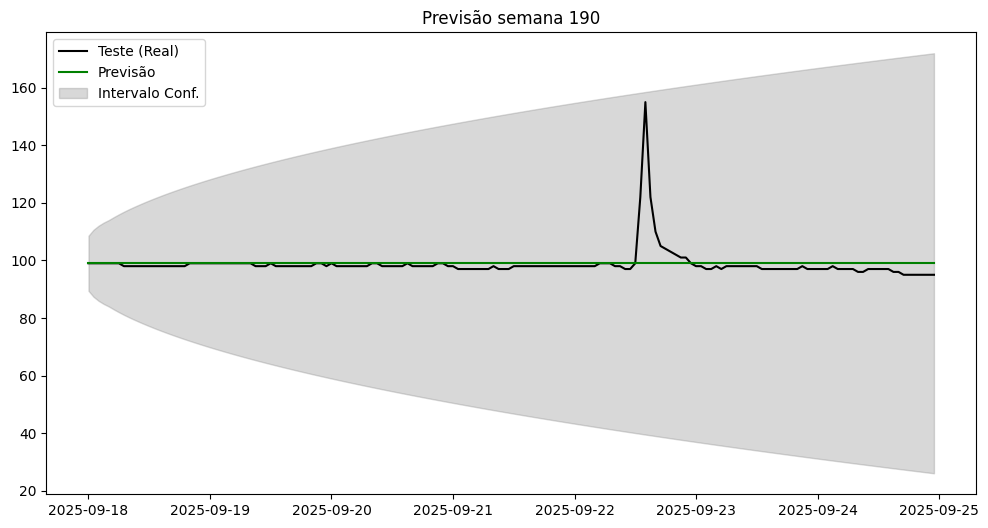

Semana 190:
RMSE: 5.33, MAE: 1.93, Erro Máx: 56.00



C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


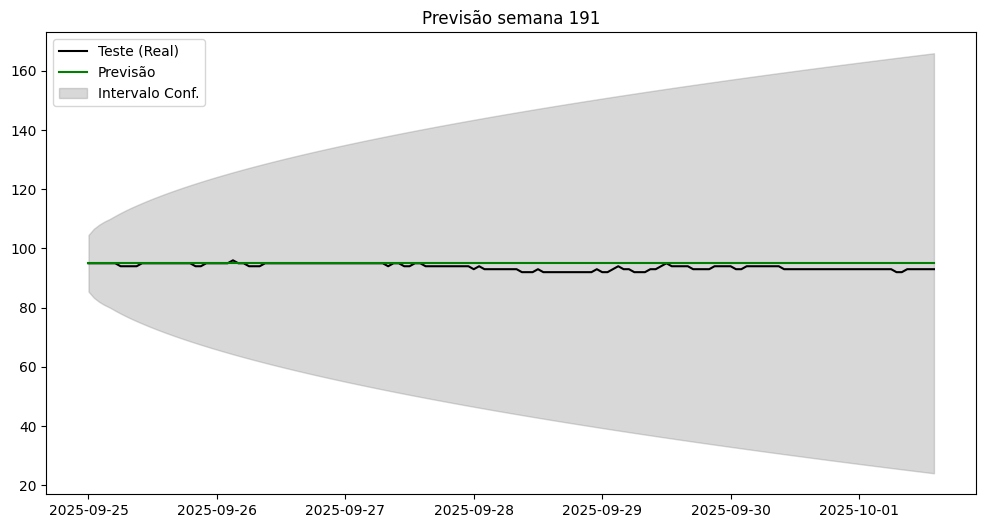

Semana 191:
RMSE: 1.61, MAE: 1.23, Erro Máx: 3.00



[{'semana': 190,
  'rmse': np.float64(5.33463525775974),
  'mae': np.float64(1.9345238095238095),
  'erro_max': np.float64(56.0)},
 {'semana': 191,
  'rmse': np.float64(1.6097189097955764),
  'mae': np.float64(1.2327044025157232),
  'erro_max': np.float64(3.0)}]

In [118]:
rolling_forecast_arima(df_jus_test['Nível (cm)'], order=(4,1,0), steps=168, start=31904)

## Previsões a Montante

C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


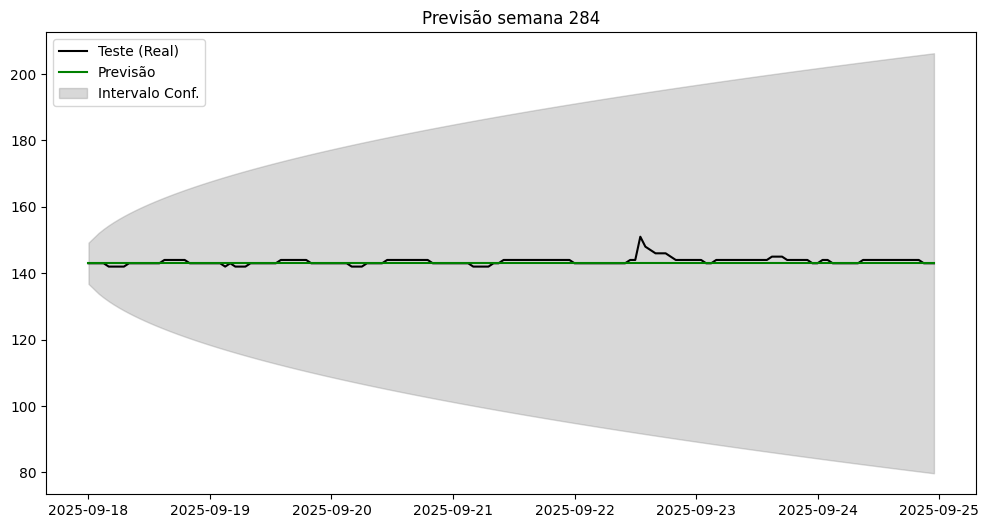

Semana 284:
RMSE: 1.18, MAE: 0.72, Erro Máx: 8.00



C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


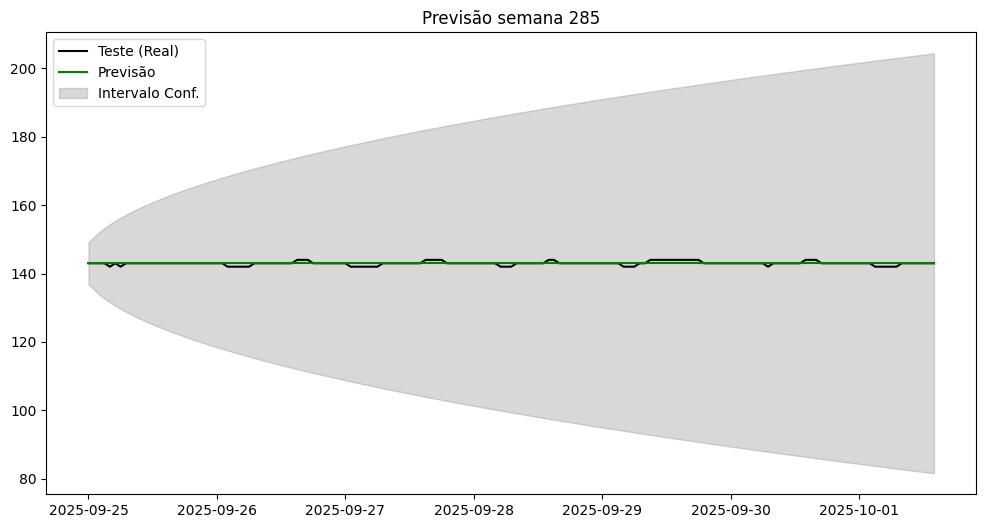

Semana 285:
RMSE: 0.54, MAE: 0.30, Erro Máx: 1.00



[{'semana': 284,
  'rmse': np.float64(1.1827127816209326),
  'mae': np.float64(0.7202380952380952),
  'erro_max': np.float64(8.0)},
 {'semana': 285,
  'rmse': np.float64(0.5436887751983938),
  'mae': np.float64(0.29559748427672955),
  'erro_max': np.float64(1.0)}]

In [121]:
rolling_forecast_arima(df_mon_test['Nível (cm)'], order=(1,1,0), steps=168, start=47673)

In [119]:
df_mon_test

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
timestamp,,,
2020-04-03 15:00:00,0.0,120.0,1.64
2020-04-03 16:00:00,0.0,120.0,1.64
2020-04-03 17:00:00,0.0,120.0,1.64
2020-04-03 18:00:00,0.0,120.0,1.64
2020-04-03 19:00:00,0.0,120.0,1.64
...,...,...,...
2025-10-01 10:00:00,0.0,143.0,1.01
2025-10-01 11:00:00,0.0,143.0,1.01
2025-10-01 12:00:00,0.0,143.0,1.01


In [120]:
df_mon[:-168]

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
timestamp,,,
2020-04-03 15:00:00,0.0,120.0,1.64
2020-04-03 16:00:00,0.0,120.0,1.64
2020-04-03 17:00:00,0.0,120.0,1.64
2020-04-03 18:00:00,0.0,120.0,1.64
2020-04-03 19:00:00,0.0,120.0,1.64
...,...,...,...
2025-09-10 19:00:00,0.0,144.0,1.12
2025-09-10 20:00:00,0.0,144.0,1.12
2025-09-10 21:00:00,0.0,144.0,1.12


In [97]:

len(df_jus_filt.iloc[:-168])

31904

In [108]:
df_mon

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
timestamp,,,
2020-04-03 15:00:00,0.0,120.0,1.64
2020-04-03 16:00:00,0.0,120.0,1.64
2020-04-03 17:00:00,0.0,120.0,1.64
2020-04-03 18:00:00,0.0,120.0,1.64
2020-04-03 19:00:00,0.0,120.0,1.64
...,...,...,...
2025-09-17 19:00:00,NaN,NaN,NaN
2025-09-17 20:00:00,NaN,NaN,NaN
2025-09-17 21:00:00,NaN,NaN,NaN


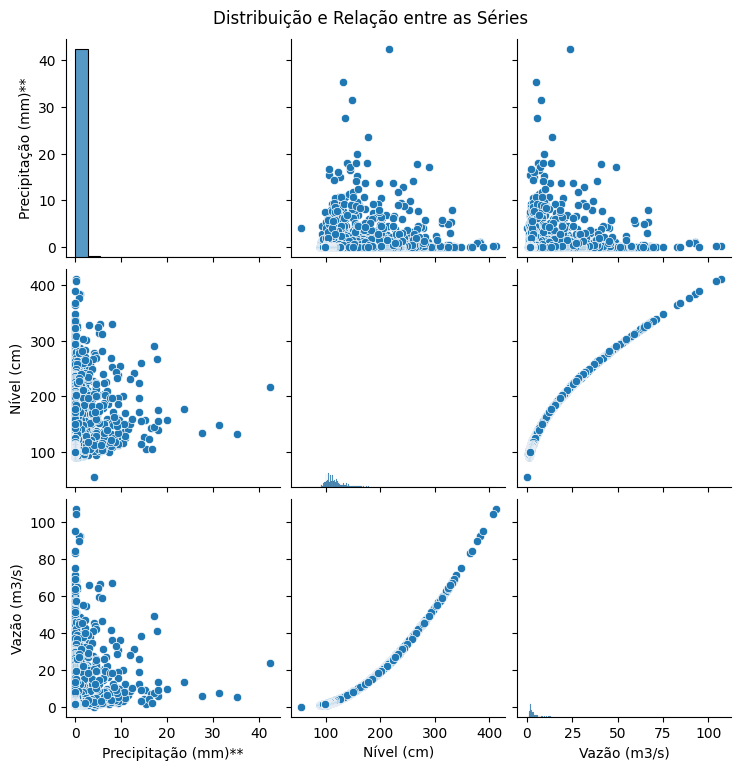

In [23]:
# Cria o pairplot para as colunas de interesse
sns.pairplot(df[['Precipitação (mm)**', 'Nível (cm)', 'Vazão (m3/s)']])

plt.suptitle('Distribuição e Relação entre as Séries', y=1.02) # Título acima dos plots
plt.show()

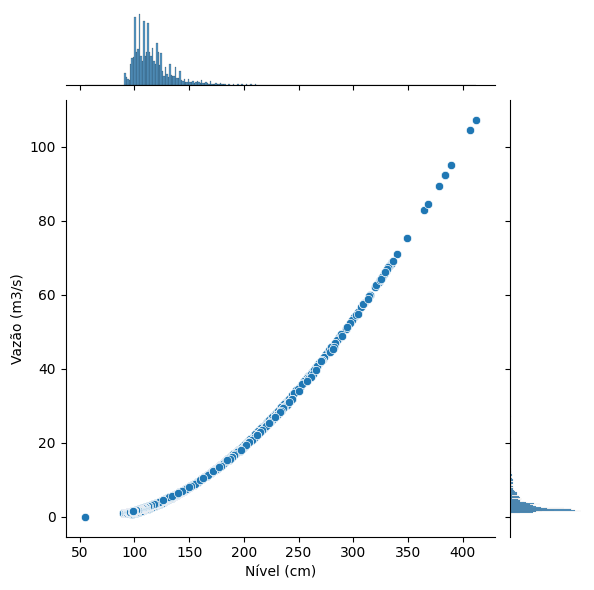

In [24]:
sns.jointplot(data=df, x='Nível (cm)', y='Vazão (m3/s)', kind='scatter')

plt.show()

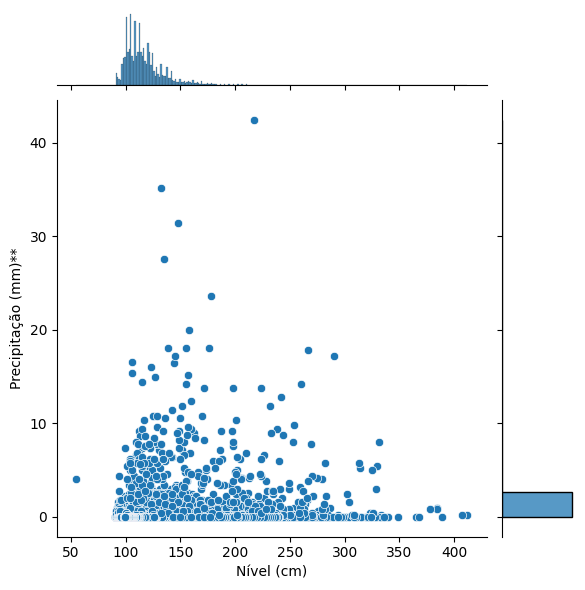

In [25]:
sns.jointplot(data=df, x='Nível (cm)', y='Precipitação (mm)**', kind='scatter')

plt.show()